In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from lightgbm import LGBMRegressor


import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

# Data Analysis

#### ვნახოთ როგორია ცვეტების და სტრიქონების რაოდენობა, სვეტების ტიპები, გამოტოვებული მონაცემები, ცვლადების განაწილებები და ა.შ.

In [4]:
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Id ეგრევე ამოვაგდოთ, რადგან არ გვჭირდება ტრენინგისთვის.

In [5]:
train = train.drop('Id', axis=1)
train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
train.shape

(1460, 80)

#### ვნახოთ სვეტების შესახებ ინფორმაცია, რა ტიპის ცვლადებია, არის თუ არა გამოტოვებული მონაცემები და ა.შ.

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

#### როგორც ვხედავთ, გვაქვს როგორც categorical, ისე numerical ცვლადები.

#### ვნახოთ target სვეტის ანუ "SalePrice"-ის აღწერითი სტატისტიკა და განაწილება.

In [8]:
train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

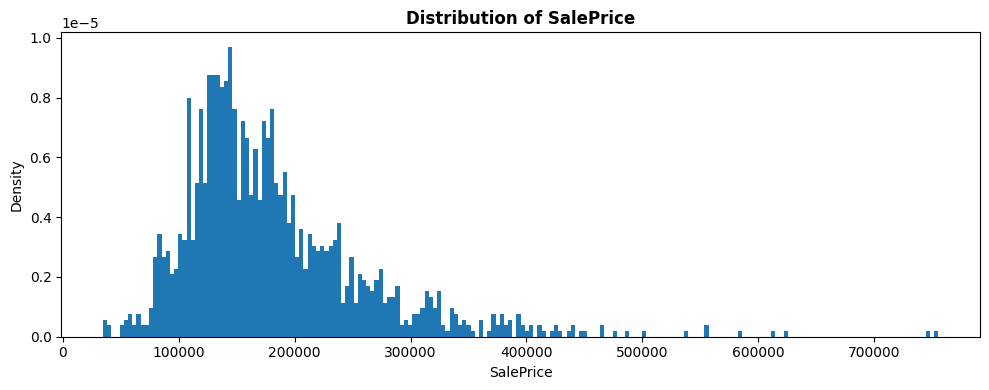

In [9]:
plt.figure(figsize=(10, 4))
plt.hist(train["SalePrice"], bins=200, density=True, histtype='bar')
plt.xlabel("SalePrice")
plt.ylabel("Density")
plt.title(f"Distribution of SalePrice", fontweight='bold')
plt.tight_layout()
plt.savefig("Distribution_of_SalePrice_in_train_set.png")
plt.show()

#### ამოვიღოთ categorical და numerical სვეტები, ვნახოთ მათი განაწილებები.

In [10]:
cat_cols = [col for col in train.columns if train[col].dtype == "object"]
num_cols = [col for col in train.columns if train[col].dtype != "object"]

In [11]:
df_cat = train[cat_cols]
df_cat.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [12]:
df_num = train[num_cols]
df_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000


#### Categorical Columns Distribution

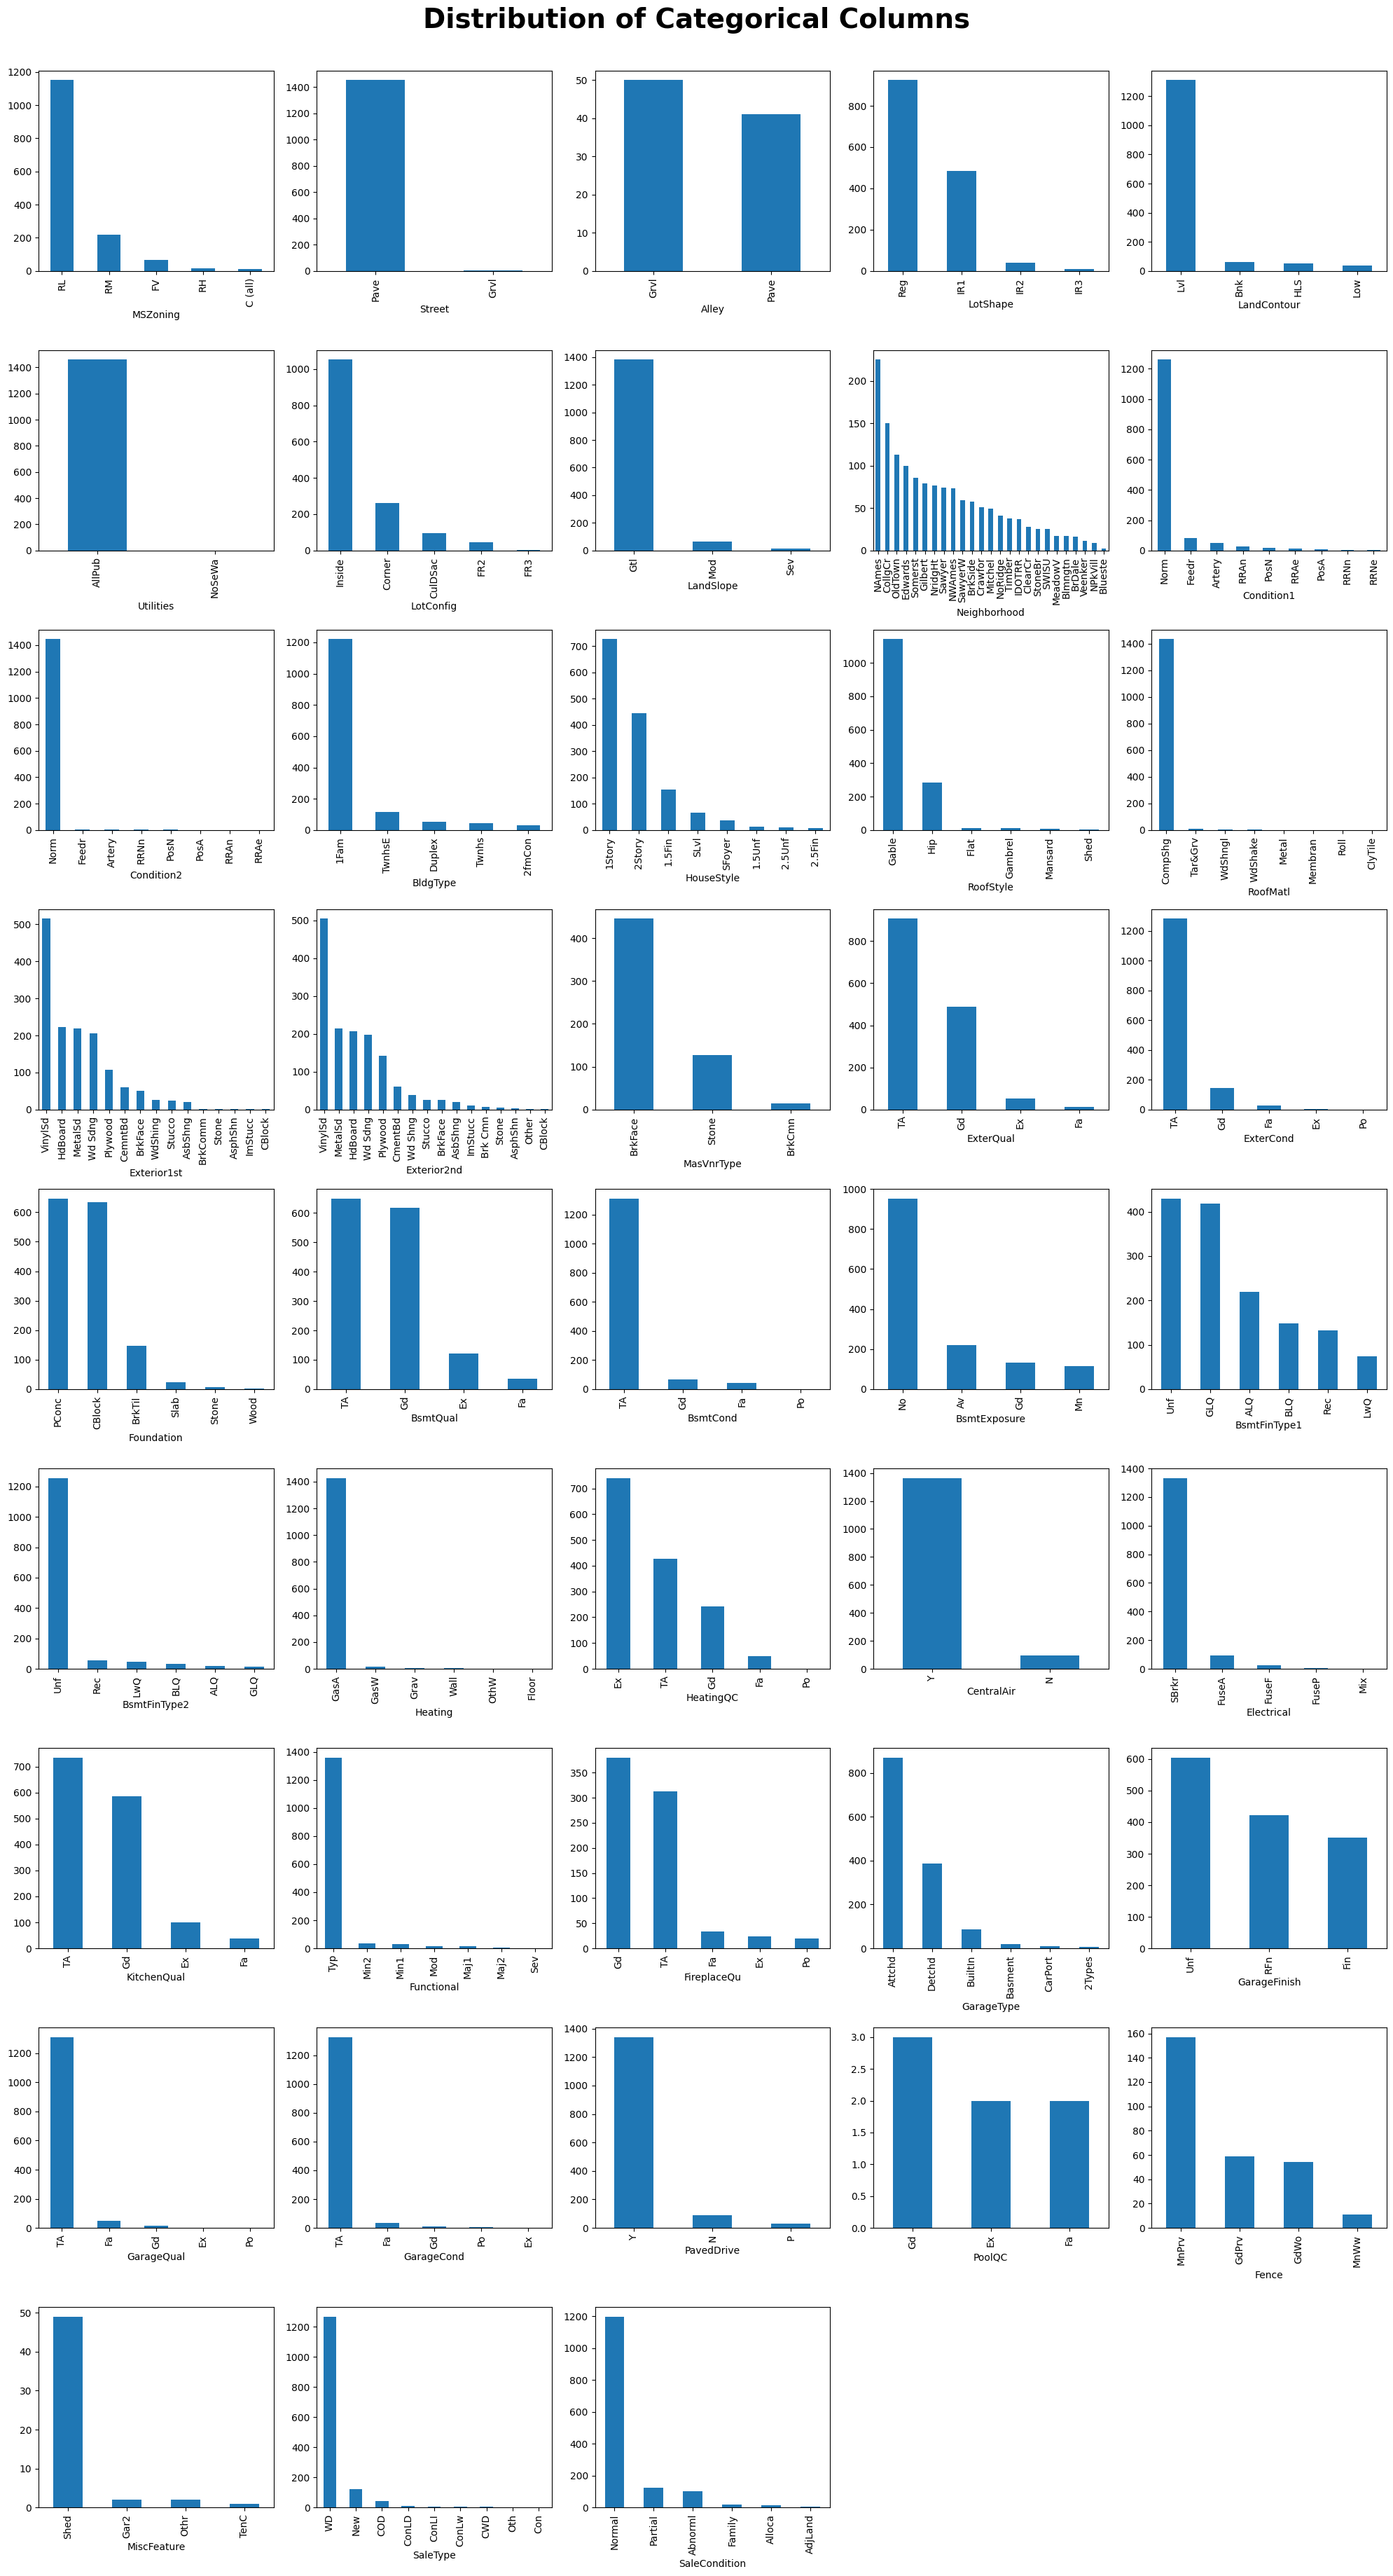

In [13]:
fig, axes = plt.subplots(9, 5, figsize=(20, 36))
axes = axes.flatten()

for i, col in enumerate(cat_cols):  
    df_cat[col].value_counts().plot(kind='bar', ax=axes[i])

fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
plt.tight_layout()
fig.suptitle("Distribution of Categorical Columns", fontsize=28, fontweight='bold', y=1.02)
plt.savefig("Distribution_of_cat_cols_in_train_set.png")
plt.show()

#### Numerical Columns Distribution

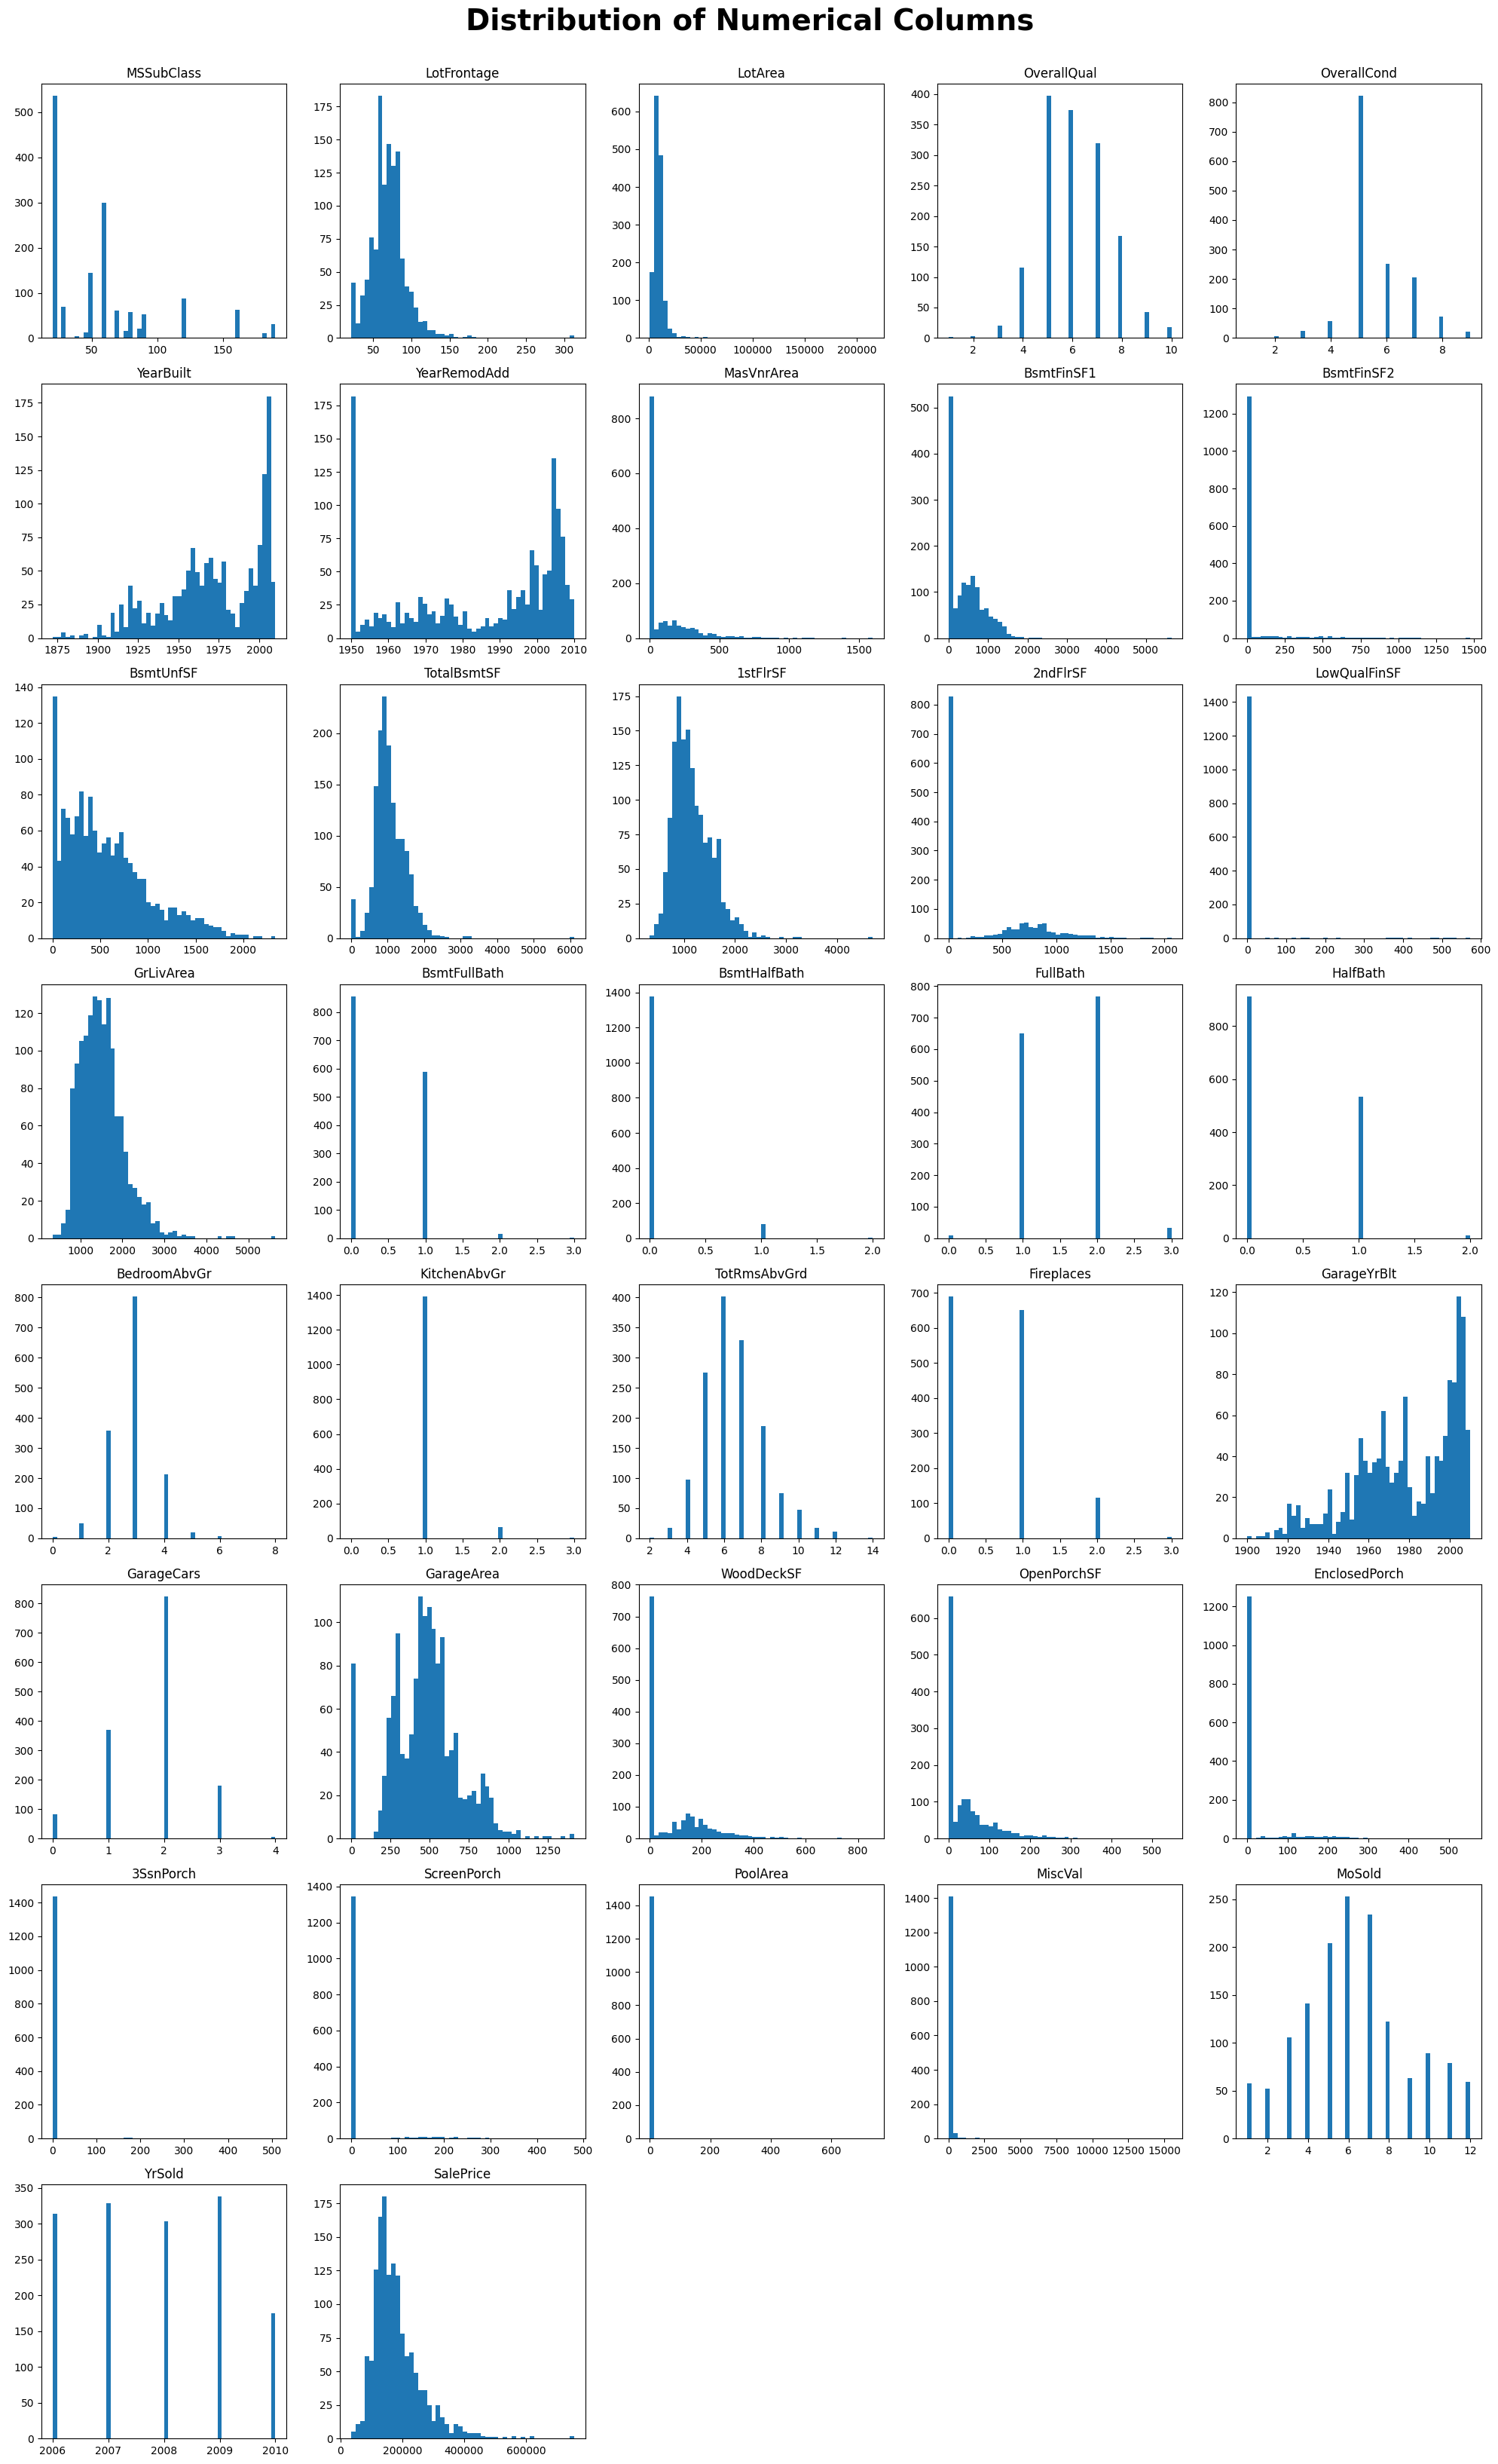

In [14]:
#df_num.hist(figsize=(25, 25), bins=50);

fig, axes = plt.subplots(8, 5, figsize=(20, 32))  
axes = axes.flatten()

for i, col in enumerate(num_cols):
    axes[i].hist(df_num[col], bins=50)
    axes[i].set_title(col, fontsize=12)


fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
fig.delaxes(axes[-3])
plt.tight_layout()
fig.suptitle("Distribution of Numerical Columns", fontsize=28, fontweight='bold', y=1.02)
plt.savefig("Distribution_of_num_cols_in_train_set.png")
plt.show()

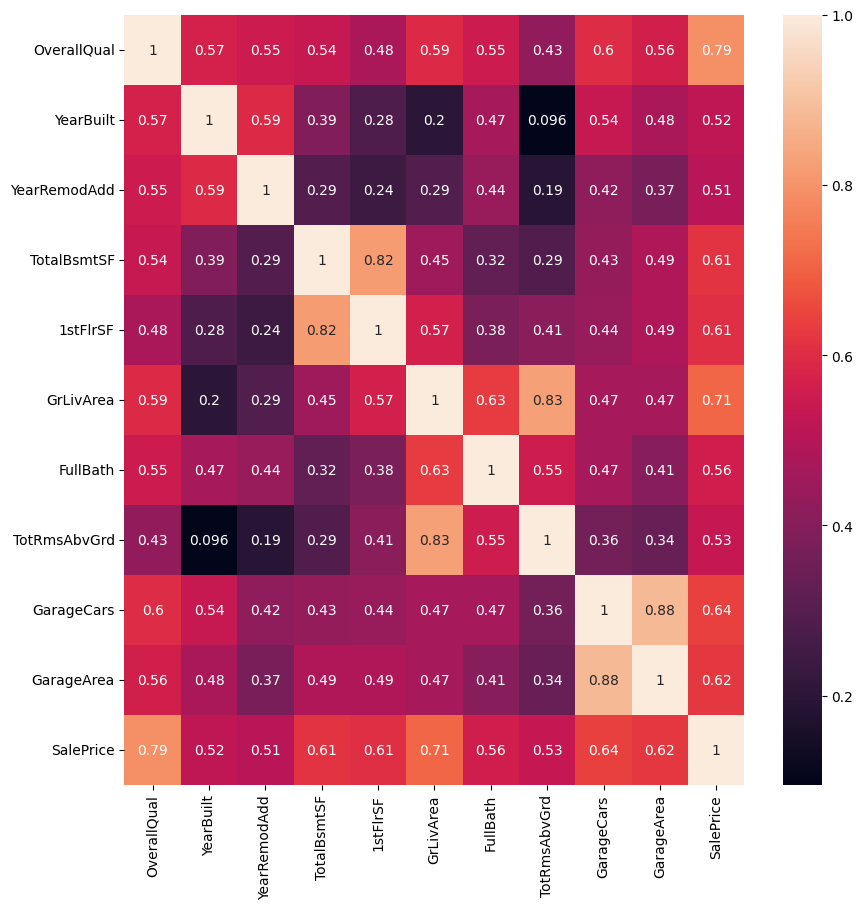

In [15]:
corr_matrix = df_num.corr()
top_corr_features = corr_matrix.index[abs(corr_matrix["SalePrice"]) > 0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(df_num[top_corr_features].corr(), annot=True)

plt.savefig("strongly_corr_cols_with_target.png")

#### ვნახოთ გამოტოვებული მონაცემების რაოდენობა და პროცენტულობა როგორც categorical, ისე numerical სვეტებში.

In [16]:
# Null value count in categorical columns
cols_with_nulls = df_cat.columns[df_cat.isna().sum() > 0]

cat_cols_null_values = pd.DataFrame(
    {
        "Cat Column" : cols_with_nulls,
        "Count": df_cat[cols_with_nulls].isna().sum(),
        "%": (df_cat[cols_with_nulls].isna().sum() / len(df_cat) * 100).round(2),
    }
).sort_values(by="Count", ascending=False)


cat_cols_null_values

,Cat Column,Count,%
PoolQC,PoolQC,1453,99.52
MiscFeature,MiscFeature,1406,96.30
Alley,Alley,1369,93.77
Fence,Fence,1179,80.75
MasVnrType,MasVnrType,872,59.73
FireplaceQu,FireplaceQu,690,47.26
GarageType,GarageType,81,5.55
GarageFinish,GarageFinish,81,5.55
GarageQual,GarageQual,81,5.55
GarageCond,GarageCond,81,5.55


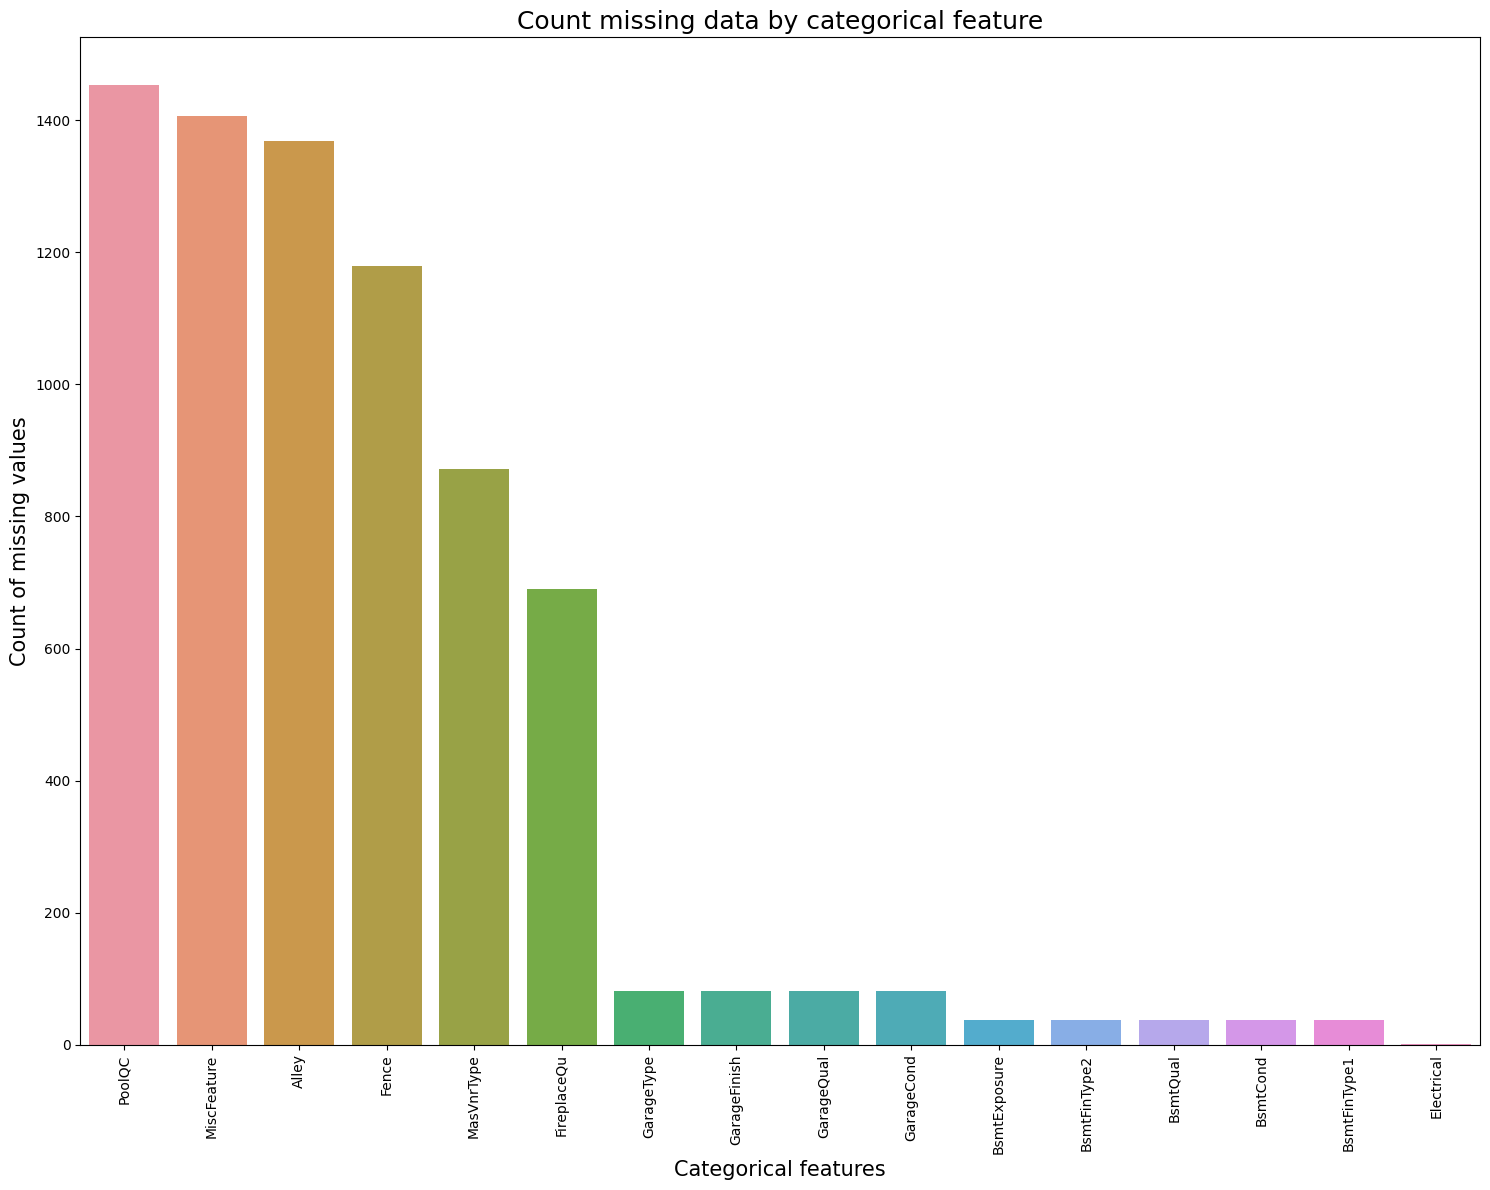

In [17]:
f, ax = plt.subplots(figsize=(15, 12))

sns.barplot(
    x="Cat Column", 
    y="Count",   
    data=cat_cols_null_values,
    ax=ax
)

ax.set_xlabel('Categorical features', fontsize=15)
ax.set_ylabel('Count of missing values', fontsize=15)  
ax.set_title('Count missing data by categorical feature', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.tight_layout()
plt.savefig("missing_data_count_cat_cols.png")
plt.show()

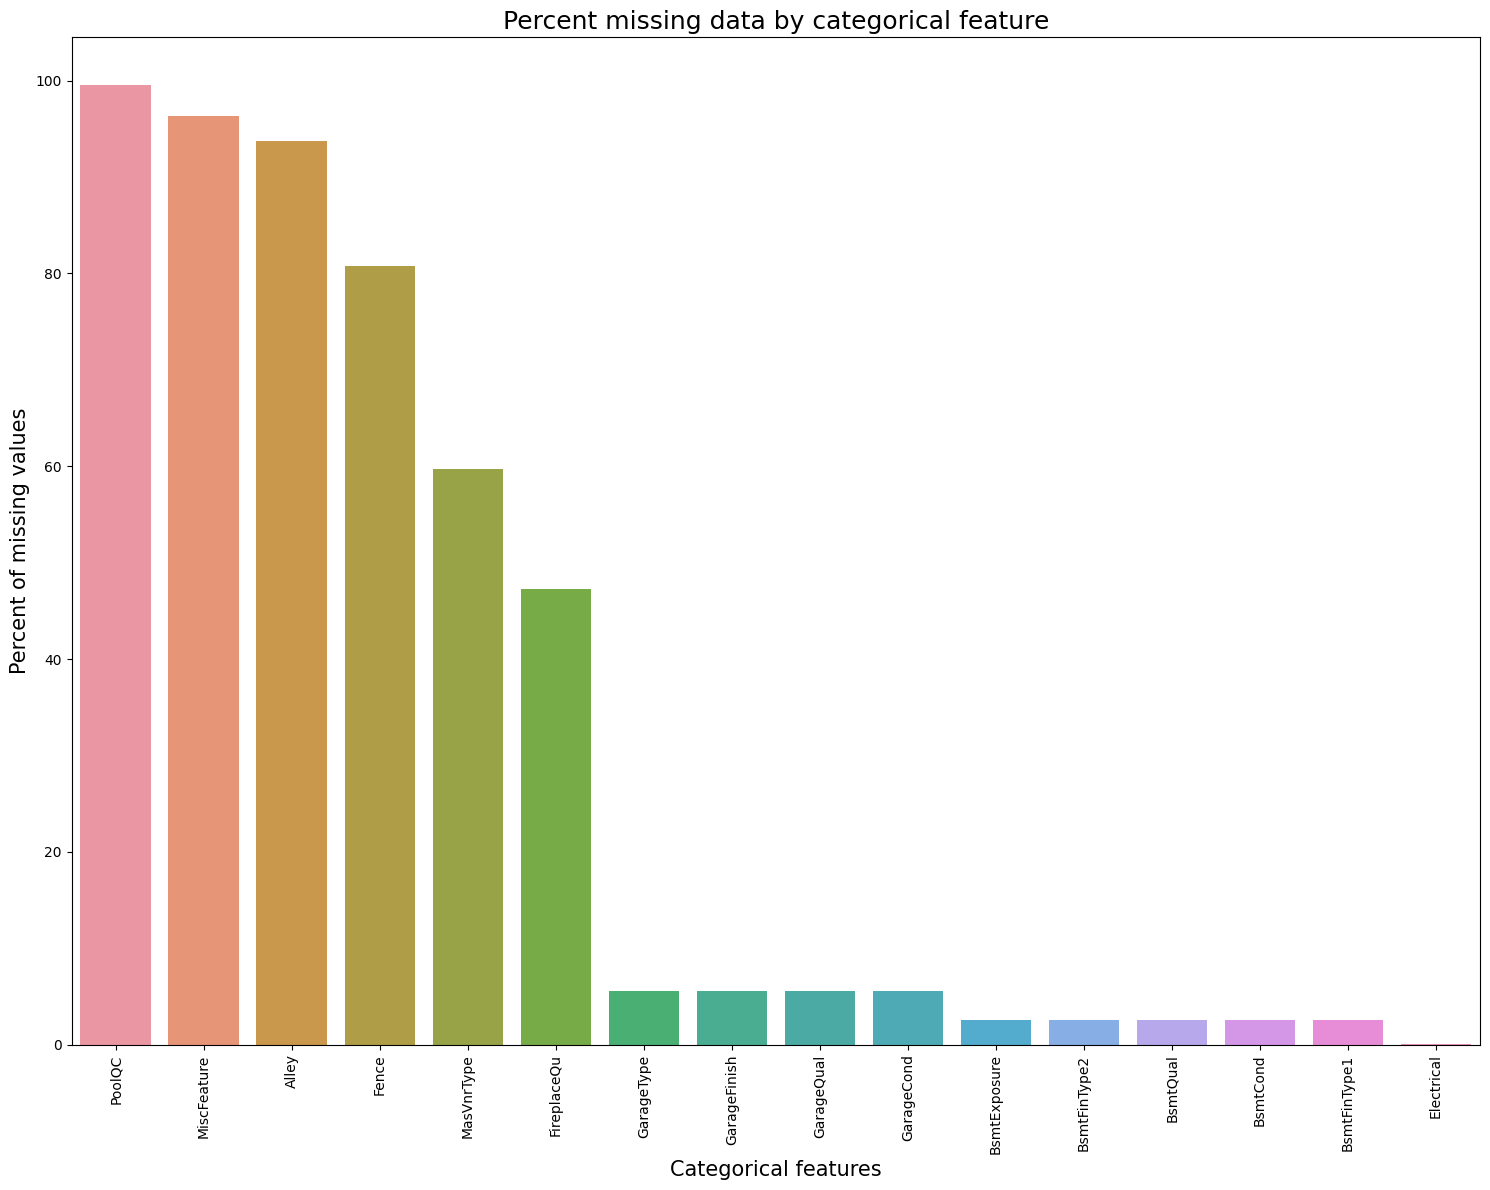

In [18]:
f, ax = plt.subplots(figsize=(15, 12))

sns.barplot(
    x="Cat Column", 
    y="%",   
    data=cat_cols_null_values,
    ax=ax
)

ax.set_xlabel('Categorical features', fontsize=15)
ax.set_ylabel('Percent of missing values', fontsize=15)  
ax.set_title('Percent missing data by categorical feature', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.tight_layout()
plt.savefig("missing_data_percent_cat_cols.png")
plt.show()

In [19]:
# Null value count in numerical columns
num_cols_with_nulls = df_num.columns[df_num.isna().sum() > 0]

num_cols_null_values = pd.DataFrame(
    {
        "Num Column": num_cols_with_nulls,
        "Count": df_num[num_cols_with_nulls].isna().sum(),
        "%": (df_num[num_cols_with_nulls].isna().sum() / len(df_num) * 100).round(2),
    }
).sort_values(by="Count", ascending=False)

num_cols_null_values

,Num Column,Count,%
LotFrontage,LotFrontage,259,17.74
GarageYrBlt,GarageYrBlt,81,5.55
MasVnrArea,MasVnrArea,8,0.55


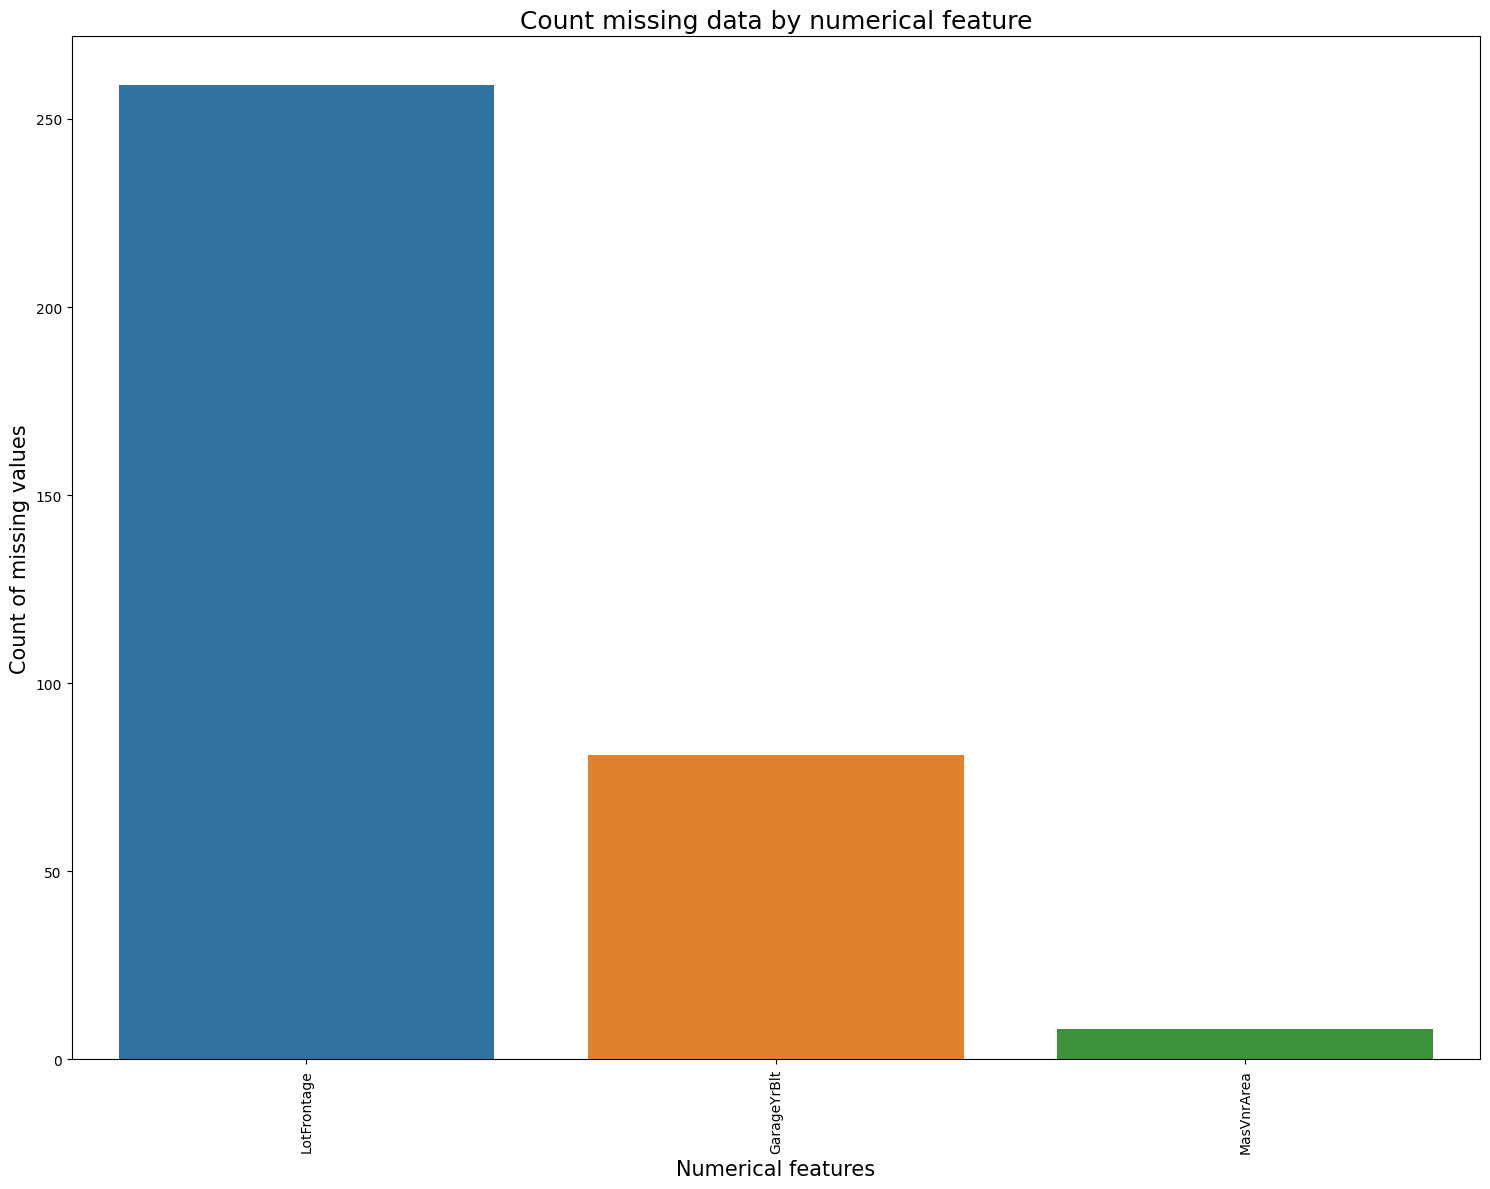

In [20]:
f, ax = plt.subplots(figsize=(15, 12))

sns.barplot(
    x="Num Column", 
    y="Count",   
    data=num_cols_null_values,
    ax=ax
)

ax.set_xlabel('Numerical features', fontsize=15)
ax.set_ylabel('Count of missing values', fontsize=15)  
ax.set_title('Count missing data by numerical feature', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.tight_layout()
plt.savefig("missing_data_count_num_cols.png")
plt.show()

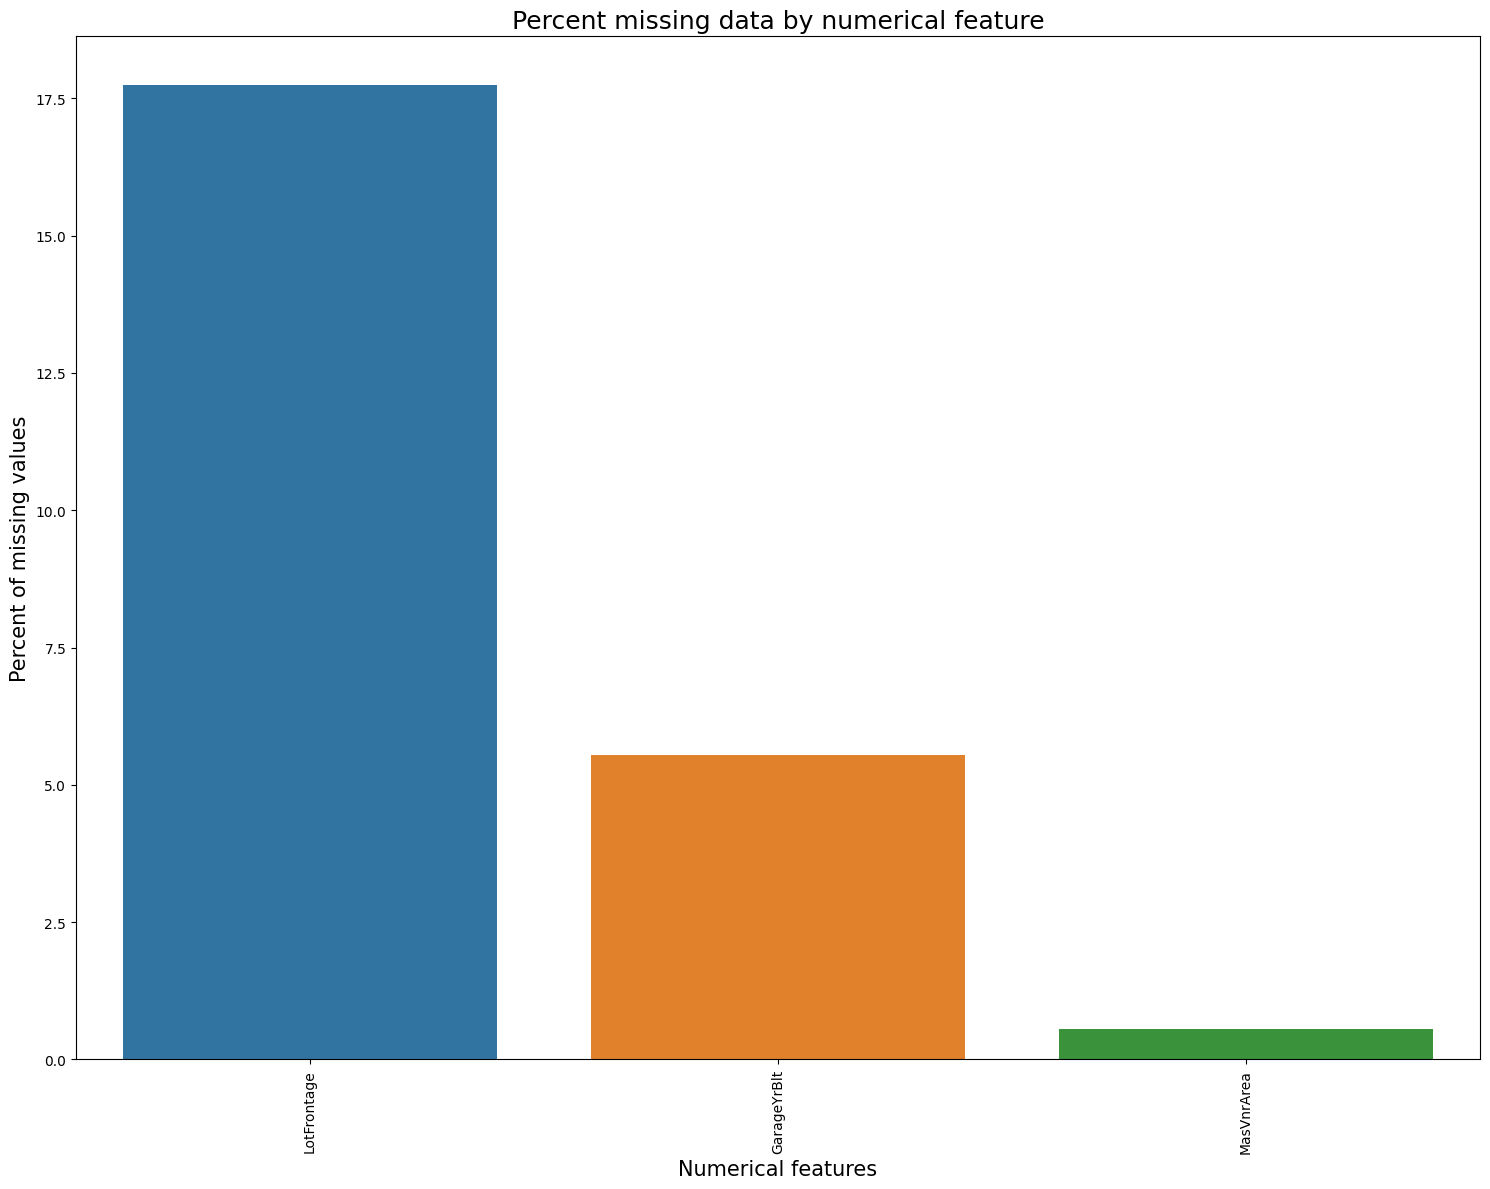

In [21]:
f, ax = plt.subplots(figsize=(15, 12))

sns.barplot(
    x="Num Column", 
    y="%",   
    data=num_cols_null_values,
    ax=ax
)

ax.set_xlabel('Numerical features', fontsize=15)
ax.set_ylabel('Percent of missing values', fontsize=15)  
ax.set_title('Percent missing data by numerical feature', fontsize=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
plt.tight_layout()
plt.savefig("missing_data_percent_num_cols.png")
plt.show()

In [22]:
pd.DataFrame(
    {
        "PoolQC- NA count" : [df_cat["PoolQC"].isna().sum()],
        "PoolArea- 0 count" : [df_num["PoolArea"][df_num["PoolArea"] == 0].count()]
    }, 
    index=[""]
)

,PoolQC- NA count,PoolArea- 0 count
,1453,1453


In [23]:
pd.DataFrame(
    {
        "MiscFeature- NA count" : [df_cat["MiscFeature"].isna().sum()],
        "MiscVal- 0 count" : [df_num["MiscVal"][df_num["MiscVal"] == 0].count()]
    }, 
    index=[""]
)

,MiscFeature- NA count,MiscVal- 0 count
,1406,1408


In [24]:
train[train["MiscVal"] == 0]["MiscFeature"].value_counts()

MiscFeature
Othr    1
Shed    1
Name: count, dtype: int64

In [25]:
pd.DataFrame(
    {
        "MasVnrType- NA count" : [df_cat["MasVnrType"].isna().sum()],
        "MasVnrArea- 0 count" : [df_num["MasVnrArea"][df_num["MasVnrArea"] == 0].count()]
    }, 
    index=[""]
)

,MasVnrType- NA count,MasVnrArea- 0 count
,872,861


In [26]:
pd.DataFrame(
    {
        "FireplaceQu- NA count" : [df_cat["FireplaceQu"].isna().sum()],
        "Fireplaces- 0 count" : [df_num["Fireplaces"][df_num["Fireplaces"] == 0].count()]
    }, 
    index=[""]
)

,FireplaceQu- NA count,Fireplaces- 0 count
,690,690


In [27]:
pd.DataFrame(
    {
        "GarageType- NA count" : [df_cat["GarageType"].isna().sum()],
        "GarageFinish- NA count" : [df_cat["GarageFinish"].isna().sum()],
        "GarageQual- NA count" : [df_cat["GarageQual"].isna().sum()],
        "GarageCond- NA count" : [df_cat["GarageCond"].isna().sum()],
        "GarageYrBlt- NA count" : [df_num["GarageYrBlt"].isna().sum()],
        "GarageArea- 0 count" : [df_num["GarageArea"][df_num["GarageArea"] == 0].count()],
        "GarageCars- 0 count" : [df_num["GarageCars"][df_num["GarageCars"] == 0].count()]
    }, 
    index=[""]
)

,GarageType- NA count,GarageFinish- NA count,GarageQual- NA count,GarageCond- NA count,GarageYrBlt- NA count,GarageArea- 0 count,GarageCars- 0 count
,81,81,81,81,81,81,81


In [28]:
pd.DataFrame(
    {
        "BsmtQual- NA count" : [df_cat["BsmtQual"].isna().sum()],
        "BsmtCond- NA count" : [df_cat["BsmtCond"].isna().sum()],
        "BsmtFinType1- NA count" : [df_cat["BsmtFinType1"].isna().sum()],
        "BsmtExposure- NA count" : [df_cat["BsmtExposure"].isna().sum()],
        "BsmtFinType2- NA count" : [df_cat["BsmtFinType2"].isna().sum()],
        "TotalBsmtSF- 0 count" : [df_num["TotalBsmtSF"][df_num["TotalBsmtSF"] == 0].count()]
    }, 
    index=[""]
)

,BsmtQual- NA count,BsmtCond- NA count,BsmtFinType1- NA count,BsmtExposure- NA count,BsmtFinType2- NA count,TotalBsmtSF- 0 count
,37,37,37,38,38,37


* 1453 (99.52%) null value გვაქვს კატეგორიულ სვეტში "PoolQC", რაც არის აუზის ხარისხი. თუ დავაკვირდებით მის შესაბამის numerical სვეტს, "PoolArea", რომელიც არის აუზის ფართობი, მისი 1453 მნიშვნელობა არის 0, რაც იმას ნიშნავს, რომ სახლების უმეტესობას აუზი არ აქვს, შესაბამისად "PoolQC" ანუ აუზის ხარისხის კატეგორიული მნიშვნელობები გამოტოვებულია.
* 1406 (96.3%) null value გვაქვს კატეგორიულ სვეტში "MiscFeature" რომელიც არის Miscellaneous feature not covered in other categories, რომლის შესაბამისი numerical ცვლადის "MiscVal"-ის ანუ $Value of miscellaneous feature-ის 1400-ზე მეტი მნიშვნელობა ასევე არის 0, რაც იმას ნიშნავს, რომ ეს მახასიათებელი სახლების უმეტესობას არ გააჩნია.
* 1369 (93.77%) null value გვაქვს კატეგორიულ სვეტში "Alley", რაც არის Type of alley access, რაც სავარაუდოდ სახლების უმეტესობას არ აქვს.
* 1179 (80.75%) null value გვაქვს კატეგორიულ სვეტში "Fence", რომელიც არის ღობის ხარისხი, ამიტომ ამდენი გამოტოვებული მონაცემის არსებობა სავარაუდოდ ნიშნავს, რომ სახლების უმეტესობას ღობე საერთოდ არ აქვს.
* 872 (59.73%) null value გვაქვს კატეგორიულ სვეტში "MasVnrType", რომელიც არის Masonry veneer type, რომლის შესაბამისი numerical სვეტია "MasVnrArea", რომლის 800-ზე მეტი მნიშვნელობა არის 0, რაც იმას ნიშნავს, რომ სახლების ნახევარზე მეტს Masonry veneer საერთოდ არ გააჩნია, შესაბამისად მისი ტიპის აღმნიშვნელი კატეგორიული ცვლადის მნიშვნელობები გამოტოვებულია.
* 690 (47.26%) null value გვაქვს კატეგორიულ სვეტში "FireplaceQu", რომელიც არის Fireplace quality. მისი შესაბამისი numerical ცვლადის "Fireplaces" ანუ Number of fireplaces, რომლის 690 მნიშვნელობა არის 0, რაც იმას ნიშნავს, რომ სახლების ამ რაოდენობას არ გააჩნია ბუხრები, შესაბამისად მისი ხარისხის აღმნიშვნელი კატეგორიული ცვლადის მნიშვნელობები ასეთი სახლებისთვის გამოტოვებულია.
* 81 (5.55%) null value გვაქვს კატეგორიულ სვეტებში "GarageType", "GarageFinish", "GarageQual", "GarageCond". მათი შესაბამისი numerical სვეტებია "GarageYrBlt"(რომელშიც ასევე 81 (5.55%) null value გვაქვს) და კიდევ "GarageCars" (Size of garage in car capacity) და "GarageArea" (Size of garage in square feet), რომლებშიც 81 მნიშვნელობა არის 0-ის ტოლი. სავარაუდოდ ჩვენი მონაცემებიდან 81 სახლს არ აქვს საერთოდ ავტოფარეხი და სწორედ ამიტომაა მათი შესაბამისი სვეტების მნიშვნელობები გამოტოვებული.
* 38 (2.6%) null value გვაქვს კატეგორიულ სვეტებში "BsmtExposure" და "BsmtFinType2", ხოლო 37 (2.53%) null value გვაქვს კატეგორიულ სვეტებში "BsmtQual", "BsmtCond" და "BsmtFinType1". ეს სვეტები არის basement-ის შესაბამისი კატეგორიული ცვლადები- მისი ხარისხი, მდგომარეობა და ტიპი. მისი შესაბამისი numerical ცვლადია "TotalBsmtSF"- Total square feet of basement area, რომლის 37 მნიშვნელობა არის 0, რაც იმას ნიშნავს, რომ მის შესაბამის კატეგორიულ სვეტებში გამოტოვებული მონაცემების არსებობა სავარაუდოდ აიხსნება იმით, რომ ამ სახლებს საერთოდ არ აქვთ basement.
* 1 (0.07%) null value გვაქვს კატეგორიულ სვეტში "Electrical", რომელიც არის Electrical system.

* 259 (17.74%) null value გვაქვს numerical სვეტში "LotFrontage" (Linear feet of street connected to property).
* 81 (5.55%) null value გვაქვს numerical სვეტში "GarageYrBlt", რაც უკვე აღვნიშნეთ ზემოთ.
* 8 (0.55%) null value გვაქვს numerical სვეტში "MasVnrArea" (Masonry veneer area in square feet).

# Cleaning & Feature Engineering

სანამ დავიწყებთ cleaning-ს და გამოტოვებული მონაცემების შევსებას, სატრენინგო მონაცემები გავყოთ სატრენინგო და სატესტო მონაცემებად (20% ავიღოთ სატესტოდ). ამას აქ იმიტომ ვაკეთებ, რომ data leakage ავირიდო თავიდან (მოდა, მედიანა, საშუალო სატესტო მონაცემებისთვის შეიძლება სხვა იყოს).

In [29]:
df_train, df_test = train_test_split(train, test_size=0.2, random_state=42)

In [30]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [31]:
df_train.shape, df_test.shape

((1168, 80), (292, 80))

კატეგორიულ სვეტებში "Alley", "PoolQC", "Fence", "MiscFeature" გამოტოვებული მნიშვნელობები შევავსოთ "None"-ით.

In [32]:
df_train["Alley"] = df_train["Alley"].fillna("None")
df_train["PoolQC"] = df_train["PoolQC"].fillna("None")
df_train["Fence"] = df_train["Fence"].fillna("None")
df_train["MiscFeature"] = df_train["MiscFeature"].fillna("None")

# df_train = df_train.drop(columns=["Alley", "PoolQC", "Fence", "MiscFeature"])

In [33]:
df_train.shape

(1168, 80)

"MasVnrType"-ში გამოტოვებული მონაცემები შევავსოთ "None"-ით, თუ მისი შესაბამისი "MasVnrArea" არის 0, სხვა შემთხვევაში შევავსოთ მოდით.

In [34]:
df_train.loc[df_train["MasVnrArea"] == 0, "MasVnrType"] = "None"
df_train["MasVnrType"] = df_train["MasVnrType"].fillna(df_train["MasVnrType"].mode()[0])

"FireplaceQu"-ში გამოტოვებული მონაცემები შევავსოთ "None"-ით.

In [35]:
df_train["FireplaceQu"] = df_train["FireplaceQu"].fillna("None")

garage-თან და basement-თან დაკავშირებულ კატეგორიულ ცვლადებში ("GarageType", "GarageFinish", "GarageQual", "GarageCond", "BsmtExposure", "BsmtFinType2", "BsmtQual", "BsmtCond", "BsmtFinType1") გამოტოვებული მონაცემები შევავსოთ "None"-ით, რადგან ავტოფარეხი და სარდაფი საერთოდ არ აქვთ ასეთ სახლებს.


In [36]:
df_train["GarageType"] = df_train["GarageType"].fillna("None")
df_train["GarageFinish"] = df_train["GarageFinish"].fillna("None")
df_train["GarageQual"] = df_train["GarageQual"].fillna("None")
df_train["GarageCond"] = df_train["GarageCond"].fillna("None")

df_train["BsmtExposure"] = df_train["BsmtExposure"].fillna("None")
df_train["BsmtFinType2"] = df_train["BsmtFinType2"].fillna("None")
df_train["BsmtQual"] = df_train["BsmtQual"].fillna("None")
df_train["BsmtCond"] = df_train["BsmtCond"].fillna("None")
df_train["BsmtFinType1"] = df_train["BsmtFinType1"].fillna("None")

"Electrical"-ში გამოტოვებული 1 მნიშვნელობა შევავსოთ მოდით. 

In [37]:
df_train["Electrical"] = df_train["Electrical"].fillna(df_train["Electrical"].mode()[0])

numerical "LotFrontage"-ში გამოტოვებული მონაცემები შევავსოთ მედიანით.

In [38]:
df_train["LotFrontage"] = df_train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)

numerical "MasVnrArea"-ში გამოტოვებული მონაცემები შევავსოთ 0-ით, თუ მისი შესაბამისი "MasVnrType" არის "None", სხვა შემთხვევაში შევავსოთ მედიანით.

In [39]:
df_train.loc[df_train["MasVnrType"] == "None", "MasVnrArea"] = 0
df_train["MasVnrArea"] = df_train["MasVnrArea"].fillna(df_train["MasVnrArea"].median())

numerical "GarageYrBlt"-ში გამოტოვებული მონაცემები შევავსოთ 0-ით, რადგან ასეთ სახლებს ავტოფარეხი არ აქვთ.

In [40]:
df_train["GarageYrBlt"] = df_train["GarageYrBlt"].fillna(0)

გადავამოწმოთ რომ null-ები არ იყოს დარჩენილი სადმე...

In [41]:
df_train.isna().sum()[df_train.isna().sum() > 0]

Series([], dtype: int64)

ასევე გადავაგდოთ ისეთი ცვლადები, რომლებსაც მხოლოდ ერთი მნიშვნელობა აქვს და არანარაირ ინფორმაციას არ გვაძლევენ.

In [42]:
df_train["Utilities"].value_counts()

Utilities
AllPub    1167
NoSeWa       1
Name: count, dtype: int64

In [43]:
df_train = df_train.drop(columns=["Utilities"])

გამოვყოთ ახალი ცვლადები.

In [44]:
df_train["TotalSF"] = df_train["TotalBsmtSF"] + df_train["1stFlrSF"] + df_train["2ndFlrSF"]

df_train["TotalBath"] = df_train["FullBath"] + 0.5 * df_train["HalfBath"] + df_train["BsmtFullBath"] + 0.5 * df_train["BsmtHalfBath"]

df_train["HasPool"] = (df_train["PoolArea"] > 0).astype(int)
df_train["HasGarage"] = (df_train["GarageArea"] > 0).astype(int)
df_train["HasBasement"] = (df_train["TotalBsmtSF"] > 0).astype(int)
df_train["HasFireplace"] = (df_train["Fireplaces"] > 0).astype(int)

df_train["PorchArea"] = df_train["OpenPorchSF"] + df_train["EnclosedPorch"] + df_train["3SsnPorch"] + df_train["ScreenPorch"]
df_train["HasPorch"] = (df_train["PorchArea"] > 0).astype(int)


In [45]:
df_train.shape

(1168, 87)

### Outliers

ვნახოთ outlier-ები. სახლს აქვს დიდი ფართობი, მაგრამ ამის მიუხედავად დაბალი ფასი, რაც ნამდვილად Outlier-ია.

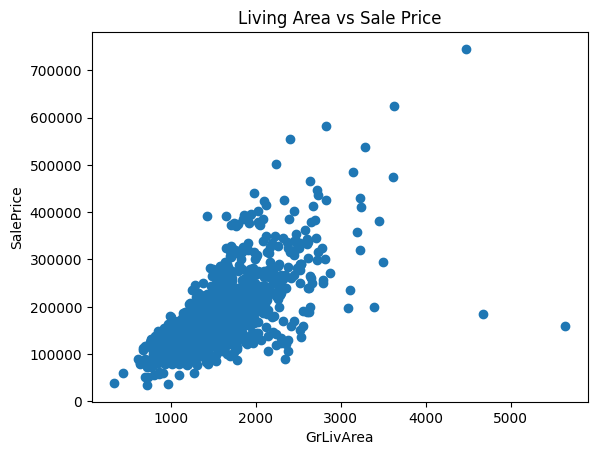

In [46]:
plt.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.title("Living Area vs Sale Price")
plt.savefig("LivingArea_SalePrice.png")
plt.show()

In [47]:
outliers = df_train[(df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 300000)]
print(outliers[['GrLivArea', 'SalePrice']])

     GrLivArea  SalePrice
365       4676     184750
495       5642     160000


In [48]:
df_train = df_train.drop(outliers.index, axis=0)

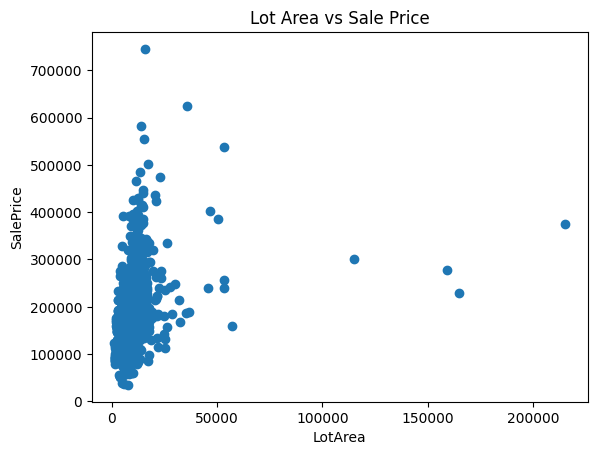

In [49]:
plt.scatter(df_train['LotArea'], df_train['SalePrice'])
plt.xlabel("LotArea")
plt.ylabel("SalePrice")
plt.title("Lot Area vs Sale Price")
plt.savefig("LotArea_SalePrice.png")
plt.show()

In [50]:
df_train = df_train[df_train['LotArea'] < 100000]

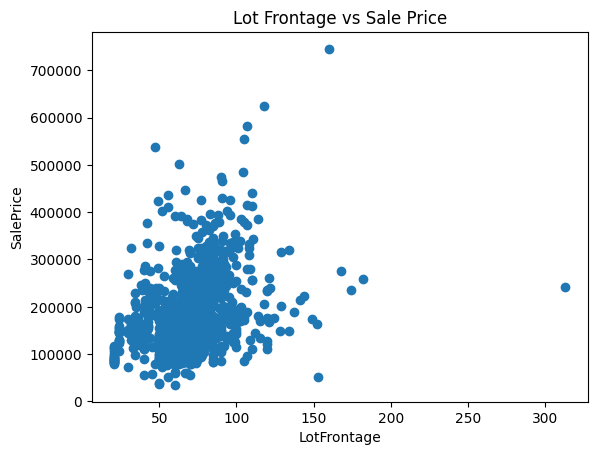

In [51]:
plt.scatter(df_train['LotFrontage'], df_train['SalePrice'])
plt.xlabel("LotFrontage")
plt.ylabel("SalePrice")
plt.title("Lot Frontage vs Sale Price")
plt.savefig("LotFrontage_SalePrice.png")
plt.show()

In [52]:
df_train = df_train[df_train['LotFrontage'] < 200]

In [53]:
df_train = df_train.reset_index(drop=True)

#### ახლა გვინდა რომ კატეგორიული ცვლადები გადავაქციოთ რიცხვითად, ამიტომ გამოვიყენოთ One Hot Encoding.

რადგან ჩვენი target ცვლადი არ არის ბინარული და არის უწყვეტი (სახლის ფასი), გვაქვს რეგრესიის ამოცანა და არა კლასიფიკაციის, ამიტომ გამოვიყენოთ One Hot Encoding.

In [54]:
cat_cols = [col for col in df_train.columns if df_train[col].dtype == "object"]
num_cols = [col for col in df_train.columns if df_train[col].dtype != "object"]

In [55]:
len(cat_cols), len(num_cols)

(42, 45)

In [56]:
one_hot_cat_cols = cat_cols

In [57]:
encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
encoded_features = encoder.fit_transform(df_train[cat_cols])
df_encoded = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cat_cols))
df_encoded = pd.concat([df_train[num_cols], df_encoded], axis=1)
print(df_encoded.head())

   MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0          20         70.0     8400            5            6       1957   
1          60         59.0     7837            6            7       1993   
2          30         67.0     8777            5            7       1910   
3          50         60.0     7200            5            7       1937   
4          50         50.0     5000            5            6       1924   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLI  \
0          1957         0.0         922           0  ...             0.0   
1          1994         0.0           0           0  ...             0.0   
2          1950         0.0           0           0  ...             0.0   
3          1950       252.0         569           0  ...             0.0   
4          1950         0.0         218           0  ...             0.0   

   SaleType_ConLw  SaleType_New  SaleType_Oth  SaleType_WD  \
0             0.0       

In [58]:
len(df_encoded.columns)

264

In [59]:
num_all_cols_after_one_hot = len(df_encoded.columns)

# Feature Selection

მიღებული 264 ცვლადისთვის (სვეტისთვის) დავითვალოთ კორელაციის მატრიცა.

In [60]:
corr_matrix = df_encoded.corr()

# too many features, hard to plot correlation matrix
# plt.figure(figsize=(12, 8))
# sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
# plt.title("Correlation Matrix")
# plt.show()

თავდაპირველად კორელაციის threshold ავიღოთ 0.5 და გავფილტროთ მიღებული 264 ცვლადი.

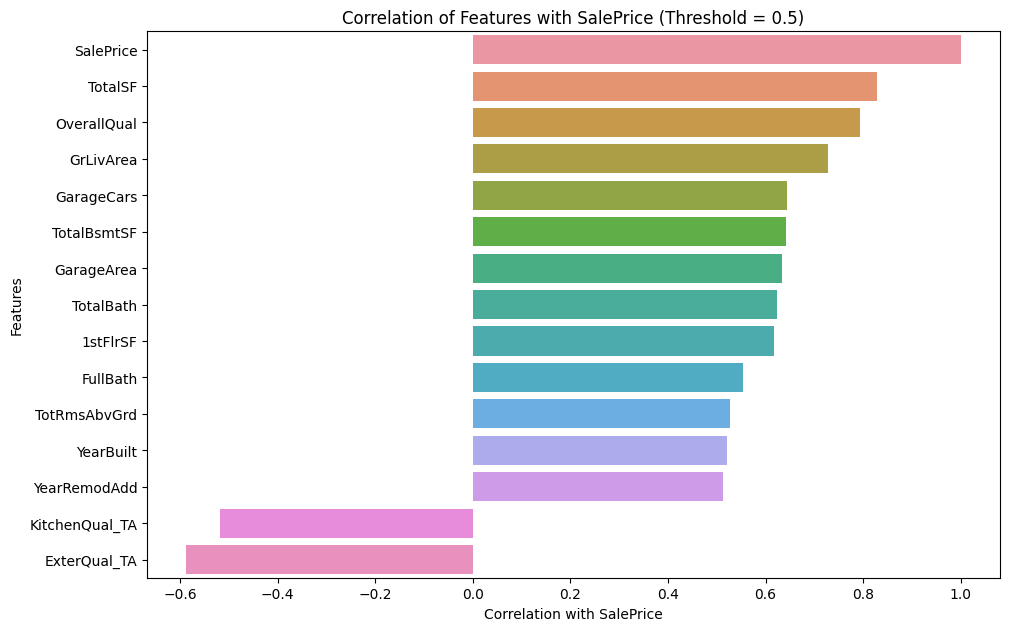

In [61]:
target_corr = corr_matrix["SalePrice"]
corr_features_1 = target_corr[(abs(target_corr) > 0.5)].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=corr_features_1.values, y=corr_features_1.index)
plt.tight_layout()
plt.xlabel('Correlation with SalePrice')
plt.ylabel('Features')
plt.title('Correlation of Features with SalePrice (Threshold = 0.5)')
plt.savefig("corr_with_target_threshold_0.5.png")
plt.show()

In [62]:
corr_features_1

SalePrice         1.000000
TotalSF           0.827965
OverallQual       0.793951
GrLivArea         0.728055
GarageCars        0.643316
TotalBsmtSF       0.642368
GarageArea        0.633283
TotalBath         0.624338
1stFlrSF          0.616401
FullBath          0.553316
TotRmsAbvGrd      0.526741
YearBuilt         0.521202
YearRemodAdd      0.512541
KitchenQual_TA   -0.517627
ExterQual_TA     -0.587541
Name: SalePrice, dtype: float64

In [63]:
corr_cols_1 = corr_features_1.index.tolist()

target ცვლადის (SalePrice) ჩათვლით მივიღეთ 15 feature.

In [64]:
df_1 = df_encoded[corr_cols_1]

In [65]:
df_1.isna().sum()[df_1.isna().sum() > 0]

Series([], dtype: int64)

მიღებული 14 feature-ით (SalePrice-ის ჩაუთვლელად) KFold cross validation-ით და grid search-ით დავატრენინგოთ სხვადასხვა მოდელები (როგორც წრფივი, ისე ხეებზე დაფუძნებული მოდელები) სხვადასხვა ჰიპერპარამეტრებით, ამოვარჩიოთ თითოეული მოდელისთვის საუკეთესო ჰიპერპარამეტრები (hyperparameter tuning) RMSE-ის მიხედვით ნამდვილი მნიშვნელობების ლოგარითმსა და და-predict-ებული მნიშვნელობების ლოგარითმებს შორის (kaggle-ზე როგორც ფასდება) და ვნახოთ თითოეული მოდელის საბოლოო საშუალო cross validation-ის RMSE-ები.

In [66]:
def rmse(y_true, y_pred):
    y_pred = np.maximum(y_pred, 1)
    return np.sqrt(mean_squared_error(np.log(y_true),np.log(y_pred)))

# scikit-learn needs to maximize the score, so we set greater_is_better=False
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [67]:
X_1 = df_1.drop(["SalePrice"], axis=1)
y_1 = df_1["SalePrice"]

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scalers = [
    StandardScaler(),
    MinMaxScaler(),
    None
]

models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {
            "scaler": scalers
        }  
    },
    "Ridge Regression": {
        "model": Ridge(),
        "params": {
            "scaler": scalers, 
            "regressor__alpha": [1, 5, 10, 20],
            "regressor__solver": ["auto", "svd", "cholesky", "lsqr"]
        }
    },
    "Lasso Regression": {
        "model": Lasso(),
        "params": {
            "scaler": scalers, 
            "regressor__alpha": [200, 300, 500, 1000]
        }
    },
    "ElasticNet": {
        "model": ElasticNet(),
        "params": {
            "scaler": scalers, 
            "regressor__alpha": [0.5, 1, 5],  
            "regressor__l1_ratio": [0.05, 0.1, 0.5, 1]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(),
        "params": {
            "scaler": scalers, 
            "regressor__max_depth": [5, 10, 15, 20, 30],
            "regressor__min_samples_split": [2, 5, 7, 10],
            "regressor__min_samples_leaf": [1, 2, 5, 10, 15],
            "regressor__max_features": ["sqrt", "log2", None]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "scaler": scalers,
            "regressor__max_depth": [5, 10, 15],
            "regressor__min_samples_split": [2, 5, 7],
            "regressor__min_samples_leaf": [1, 2, 5],
            "regressor__max_features": ['sqrt', 'log2'],
            "regressor__n_estimators": [100, 200, 300]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(),
        "params": {
            "scaler": scalers,
            "regressor__learning_rate": [0.01, 0.05, 0.1],
            "regressor__max_depth": [3, 5, 7],
            "regressor__gamma": [0, 0.1, 0.5], 
            "regressor__n_estimators": [100, 200, 300]
        }
    }
}

best_models_1 = {}
best_scores_1 = {}

for name, config in models.items():
    print(f"Training {name}...")

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", config["model"])
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid=config["params"],
        cv=kfold,
        scoring=rmse_scorer,
        return_train_score=True
    )

    grid_search.fit(X_1, y_1)
    best_models_1[name] = grid_search.best_params_
    best_scores_1[name] = -grid_search.best_score_

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation error: {-grid_search.best_score_:.4f}\n")


for name, params in best_models_1.items():
    print(f"{name}: Best parameters = {params}")
    
for name, score in best_scores_1.items():
    print(f"{name}: Best RMSE = {score:.4f}")


Training Linear Regression...
Best parameters for Linear Regression: {'scaler': None}
Best cross-validation error: 0.4033

Training Ridge Regression...
Best parameters for Ridge Regression: {'regressor__alpha': 20, 'regressor__solver': 'svd', 'scaler': MinMaxScaler()}
Best cross-validation error: 0.1713

Training Lasso Regression...
Best parameters for Lasso Regression: {'regressor__alpha': 1000, 'scaler': MinMaxScaler()}
Best cross-validation error: 0.1852

Training ElasticNet...
Best parameters for ElasticNet: {'regressor__alpha': 1, 'regressor__l1_ratio': 0.05, 'scaler': StandardScaler()}
Best cross-validation error: 0.1712

Training Decision Tree...
Best parameters for Decision Tree: {'regressor__max_depth': 10, 'regressor__max_features': None, 'regressor__min_samples_leaf': 15, 'regressor__min_samples_split': 5, 'scaler': StandardScaler()}
Best cross-validation error: 0.1770

Training Random Forest...
Best parameters for Random Forest: {'regressor__max_depth': 15, 'regressor__max_

K-Fold Cross Validation-ით საუკეთესო შედეგი ანუ მინიმალური error ჰქონდა XGBoost-ს (RMSE = 0.1402), ამიტომ ამ feature-ებისთვის საუკეთესო მოდელი არის XGBoost შემდეგი ჰიპერპარამეტრებით: Best parameters = {'regressor__gamma': 0, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 100, 'scaler': StandardScaler()}

ახლა კორელაციის threshold ავიღოთ 0.55 და ვნახოთ ნაკლები feature-ით თუ გვექნება უკეთესი შედეგი თითოეული მოდელისთვის.

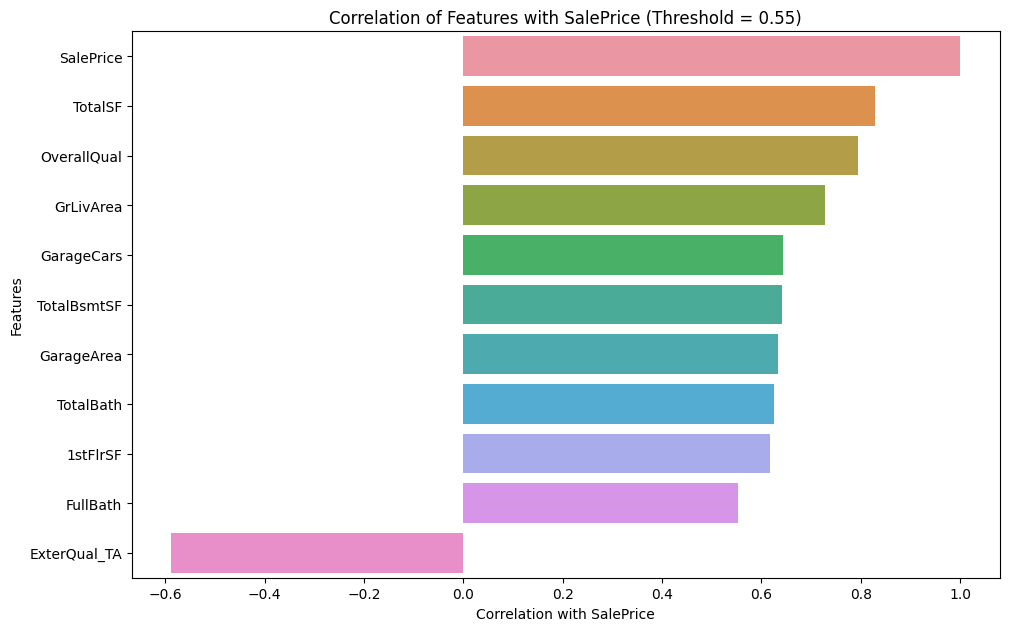

In [68]:
target_corr = corr_matrix["SalePrice"]
corr_features_2 = target_corr[(abs(target_corr) > 0.55)].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=corr_features_2.values, y=corr_features_2.index)
plt.tight_layout()
plt.xlabel('Correlation with SalePrice')
plt.ylabel('Features')
plt.title('Correlation of Features with SalePrice (Threshold = 0.55)')
plt.savefig("corr_with_target_threshold_0.55.png")
plt.show()

In [69]:
corr_cols_2 = corr_features_2.index.tolist()
df_2 = df_encoded[corr_cols_2]

In [70]:
corr_cols_2

['SalePrice',
 'TotalSF',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'TotalBsmtSF',
 'GarageArea',
 'TotalBath',
 '1stFlrSF',
 'FullBath',
 'ExterQual_TA']

მივიღეთ 10 feature (SalePrice-ის გარდა).

In [71]:
X_2 = df_2.drop(["SalePrice"], axis=1)
y_2 = df_2["SalePrice"]

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scalers = [
    StandardScaler(),
    MinMaxScaler(),
    None
]

models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {
            "scaler": scalers
        }  
    },
   "Ridge Regression": {
        "model": Ridge(),
        "params": {
            "scaler": scalers, 
            "regressor__alpha": [1, 5, 10, 20],
            "regressor__solver": ["auto", "svd", "cholesky", "lsqr"]
        }
    },
    "Lasso Regression": {
        "model": Lasso(),
        "params": {
            "scaler": scalers, 
            "regressor__alpha": [200, 300, 500, 1000]
        }
    },
    "ElasticNet": {
        "model": ElasticNet(),
        "params": {
            "scaler": scalers, 
            "regressor__alpha": [0.5, 1, 5],  
            "regressor__l1_ratio": [0.05, 0.1, 0.5, 1]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(),
        "params": {
            "scaler": scalers, 
            "regressor__max_depth": [5, 10, 15, 20, 30],
            "regressor__min_samples_split": [2, 5, 7, 10],
            "regressor__min_samples_leaf": [1, 2, 5, 10, 15],
            "regressor__max_features": ["sqrt", "log2", None]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "scaler": scalers,
            "regressor__max_depth": [5, 10, 15],
            "regressor__min_samples_split": [2, 5, 7],
            "regressor__min_samples_leaf": [1, 2, 5],
            "regressor__max_features": ['sqrt', 'log2'],
            "regressor__n_estimators": [100, 200, 300]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(),
        "params": {
            "scaler": scalers,
            "regressor__learning_rate": [0.01, 0.05, 0.1],
            "regressor__max_depth": [3, 5, 7],
            "regressor__gamma": [0, 0.1, 0.5], 
            "regressor__n_estimators": [100, 200, 300]
        }
    }
}


best_models_2 = {}
best_scores_2 = {}

for name, config in models.items():
    print(f"Training {name}...")

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", config["model"])
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid=config["params"],
        cv=kfold,
        scoring=rmse_scorer,
        return_train_score=True
    )

    grid_search.fit(X_2, y_2)
    best_models_2[name] = grid_search.best_params_
    best_scores_2[name] = -grid_search.best_score_

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation error: {-grid_search.best_score_:.4f}\n")


for name, params in best_models_2.items():
    print(f"{name}: Best parameters = {params}")

for name, score in best_scores_2.items():
    print(f"{name}: Best RMSE = {score:.4f}")


Training Linear Regression...
Best parameters for Linear Regression: {'scaler': None}
Best cross-validation error: 0.4051

Training Ridge Regression...
Best parameters for Ridge Regression: {'regressor__alpha': 20, 'regressor__solver': 'svd', 'scaler': MinMaxScaler()}
Best cross-validation error: 0.1777

Training Lasso Regression...
Best parameters for Lasso Regression: {'regressor__alpha': 1000, 'scaler': MinMaxScaler()}
Best cross-validation error: 0.1967

Training ElasticNet...
Best parameters for ElasticNet: {'regressor__alpha': 1, 'regressor__l1_ratio': 0.05, 'scaler': StandardScaler()}
Best cross-validation error: 0.1771

Training Decision Tree...
Best parameters for Decision Tree: {'regressor__max_depth': 10, 'regressor__max_features': None, 'regressor__min_samples_leaf': 10, 'regressor__min_samples_split': 7, 'scaler': StandardScaler()}
Best cross-validation error: 0.1760

Training Random Forest...
Best parameters for Random Forest: {'regressor__max_depth': 15, 'regressor__max_

აშკარად უარესი error-ები მივიღეთ. აქაც ყველაზე კარგი შედეგი აქვს XGBoost-ს 0.1503 RMSE-ით, რაც უფრო მეტია ვიდრე წინა feature-ებით გვქონდა, ამიტომ ისევ წინა დავტოვოთ ჯერჯერობით.

ვცადოთ RFE-იც feature-ების შერჩევისთვის. ჯერ კორელაციის ფილტრით გავფილტროთ, რადგან 264 ცვლადი გვაქვს (ცოტა რომ შევამციროთ), შემდეგ კი გამოვიყენოთ RFE.

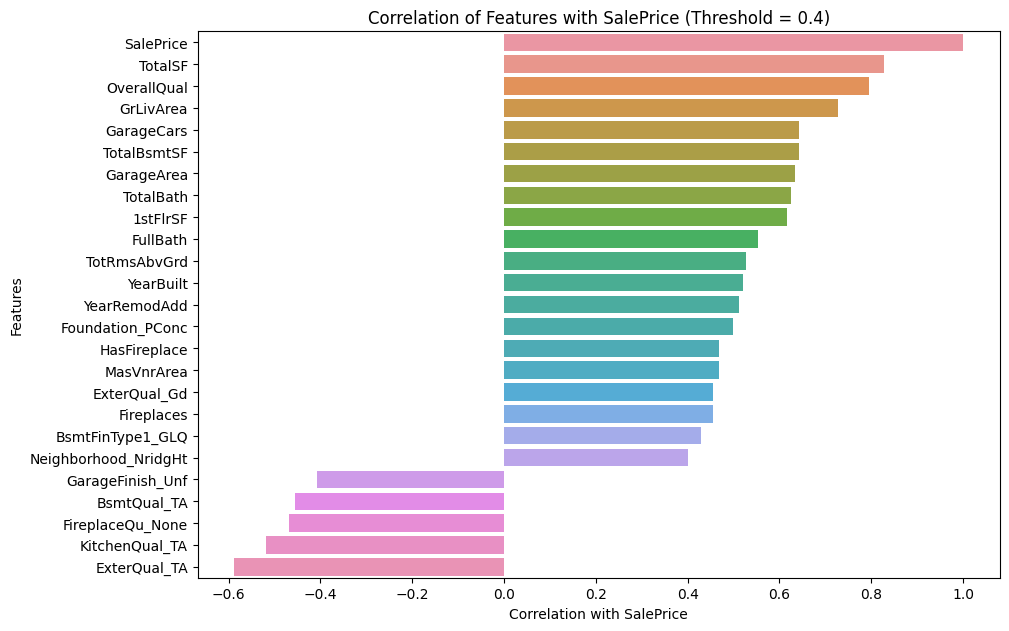

In [72]:
target_corr = corr_matrix["SalePrice"]
corr_features_3 = target_corr[(abs(target_corr) > 0.4)].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=corr_features_3.values, y=corr_features_3.index)
plt.tight_layout()
plt.xlabel('Correlation with SalePrice')
plt.ylabel('Features')
plt.title('Correlation of Features with SalePrice (Threshold = 0.4)')
plt.savefig("corr_with_target_threshold_0.4_rfe.png")
plt.show()

In [73]:
len(corr_features_3)

25

264 ცვლადიდან კორელაციის ფილტრით დავტოვეთ 25 ცვლადი, ახლა კი RFE-ით შევარჩიოთ top 10.

In [74]:
corr_cols_3 = corr_features_3.index.tolist()
df_3 = df_encoded[corr_cols_3]

Features selected by RFE:
1. TotalSF
2. OverallQual
3. GrLivArea
4. GarageCars
5. TotalBsmtSF
6. GarageArea
7. TotalBath
8. 1stFlrSF
9. YearBuilt
10. YearRemodAdd


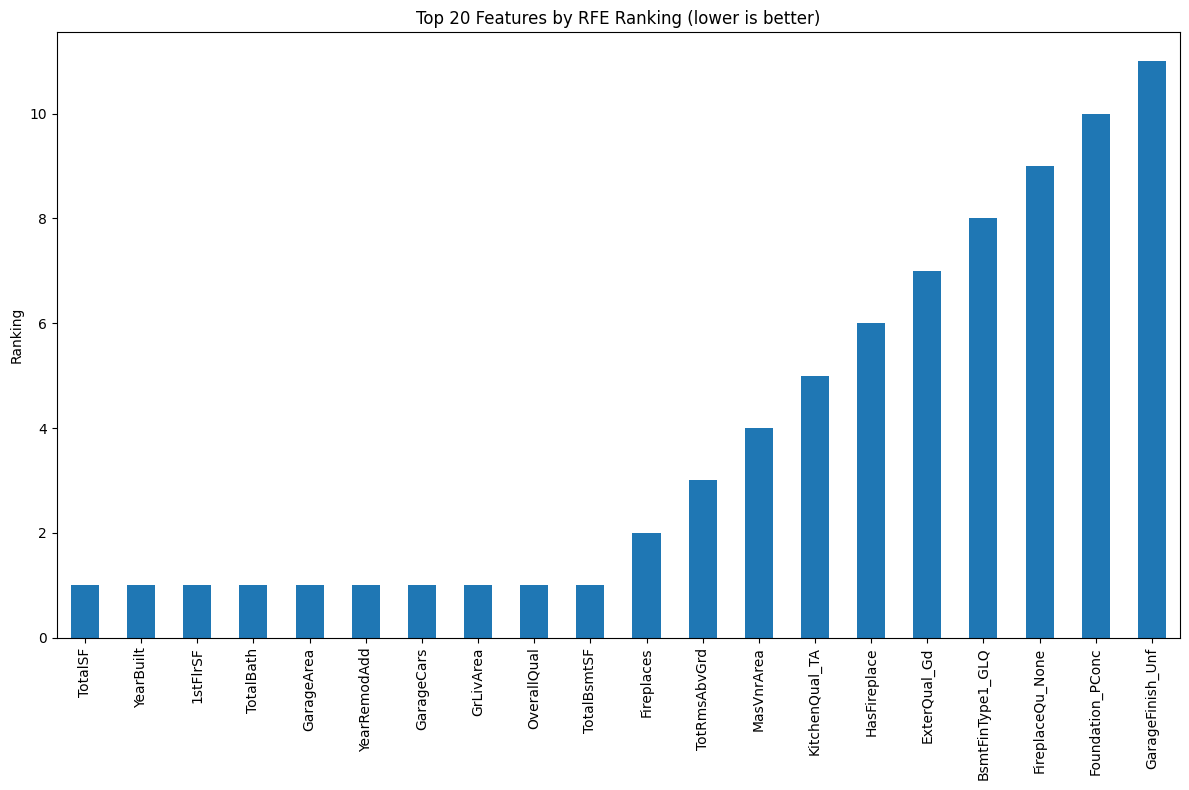

In [75]:
X_train_rfe = df_3.drop(["SalePrice"], axis=1)
y_train_rfe = df_3["SalePrice"]

scaler = StandardScaler()

X_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_rfe),
    columns=X_train_rfe.columns
)

model = RandomForestRegressor()

rfe = RFE(estimator=model, n_features_to_select=10, step=1)
rfe.fit(X_scaled, y_train_rfe)

rfe_selected_features = X_train_rfe.columns[rfe.support_].tolist()

print("Features selected by RFE:")
for i, feature in enumerate(rfe_selected_features, 1):
    print(f"{i}. {feature}")

plt.figure(figsize=(12, 8))
feature_ranking = pd.Series(rfe.ranking_, index=X_train_rfe.columns)
feature_ranking.sort_values().head(20).plot(kind='bar')
plt.title('Top 20 Features by RFE Ranking (lower is better)')
plt.ylabel('Ranking')
plt.tight_layout()
plt.savefig("rfe.png")
plt.show()

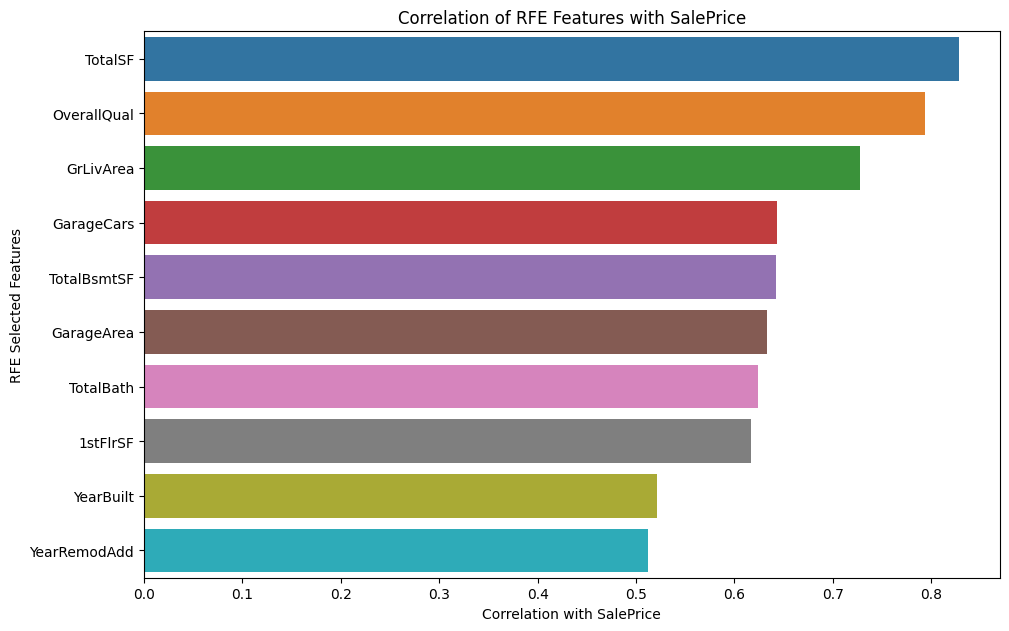

In [76]:
target_corr = corr_matrix["SalePrice"]
rfe_features_corr = target_corr[rfe_selected_features].sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=rfe_features_corr.values, y=rfe_features_corr.index)
plt.tight_layout()
plt.xlabel('Correlation with SalePrice')
plt.ylabel('RFE Selected Features')
plt.title('Correlation of RFE Features with SalePrice')
plt.savefig("corr_with_target_rfe.png")
plt.show()

ვნახოთ RFE-ით შერჩეული 10 feature რა შედეგებს მოგვცემს იგივე მოდელებისთვის.

In [77]:
X_rfe = X_train_rfe[rfe_selected_features]
y_rfe = y_train_rfe

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

scalers = [
    StandardScaler(),
    MinMaxScaler(),
    None
]

models = {
    "Linear Regression": {
        "model": LinearRegression(),
        "params": {
            "scaler": scalers
        }  
    },
     "Ridge Regression": {
        "model": Ridge(),
        "params": {
            "scaler": scalers, 
            "regressor__alpha": [1, 5, 10, 20],
            "regressor__solver": ["auto", "svd", "cholesky", "lsqr"]
        }
    },
    "Lasso Regression": {
        "model": Lasso(),
        "params": {
            "scaler": scalers, 
            "regressor__alpha": [200, 300, 500, 1000]
        }
    },
    "ElasticNet": {
        "model": ElasticNet(),
        "params": {
            "scaler": scalers, 
            "regressor__alpha": [0.5, 1, 5],  
            "regressor__l1_ratio": [0.05, 0.1, 0.5, 1]
        }
    },
    "Decision Tree": {
        "model": DecisionTreeRegressor(),
        "params": {
            "scaler": scalers, 
            "regressor__max_depth": [5, 10, 15, 20, 30],
            "regressor__min_samples_split": [2, 5, 7, 10],
            "regressor__min_samples_leaf": [1, 2, 5, 10, 15],
            "regressor__max_features": ["sqrt", "log2", None]
        }
    },
    "Random Forest": {
        "model": RandomForestRegressor(),
        "params": {
            "scaler": scalers,
            "regressor__max_depth": [5, 10, 15, 20],
            "regressor__min_samples_split": [2, 5, 7],
            "regressor__min_samples_leaf": [1, 2, 5],
            "regressor__max_features": ['sqrt', 'log2'],
            "regressor__n_estimators": [100, 300, 500]
        }
    },
    "XGBoost": {
        "model": XGBRegressor(),
        "params": {
            "scaler": scalers,
            "regressor__learning_rate": [0.01, 0.05, 0.1],
            "regressor__max_depth": [3, 5, 7],
            "regressor__gamma": [0, 0.1, 0.5], 
            "regressor__n_estimators": [100, 300, 500]
        }
    }
}

best_models_rfe = {}
best_scores_rfe = {}

for name, config in models.items():
    print(f"Training {name}...")

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("regressor", config["model"])
    ])

    grid_search = GridSearchCV(
        pipeline,
        param_grid=config["params"],
        cv=kfold,
        scoring=rmse_scorer,
        return_train_score=True
    )

    grid_search.fit(X_rfe, y_rfe)
    best_models_rfe[name] = grid_search.best_params_
    best_scores_rfe[name] = -grid_search.best_score_

    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best cross-validation error: {-grid_search.best_score_:.4f}\n")


for name, params in best_models_rfe.items():
    print(f"{name}: Best parameters = {params}")
    
for name, score in best_scores_rfe.items():
    print(f"{name}: Best RMSE = {score:.4f}")


Training Linear Regression...
Best parameters for Linear Regression: {'scaler': MinMaxScaler()}
Best cross-validation error: 0.4214

Training Ridge Regression...
Best parameters for Ridge Regression: {'regressor__alpha': 20, 'regressor__solver': 'lsqr', 'scaler': MinMaxScaler()}
Best cross-validation error: 0.2804

Training Lasso Regression...
Best parameters for Lasso Regression: {'regressor__alpha': 1000, 'scaler': MinMaxScaler()}
Best cross-validation error: 0.2931

Training ElasticNet...
Best parameters for ElasticNet: {'regressor__alpha': 5, 'regressor__l1_ratio': 0.5, 'scaler': StandardScaler()}
Best cross-validation error: 0.1879

Training Decision Tree...
Best parameters for Decision Tree: {'regressor__max_depth': 30, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 10, 'regressor__min_samples_split': 7, 'scaler': StandardScaler()}
Best cross-validation error: 0.1775

Training Random Forest...
Best parameters for Random Forest: {'regressor__max_depth': 20, 'reg

საუკეთესო შედეგი ისევ აქვს XGBoost-ს (RMSE = 0.1433), რაც უფრო ცუდი შედეგია, ვიდრე პირველ შემთხვევაში (RMSE = 0.1402), ამიტომ ისევ პირველი feature-ები დავტოვოთ. 

# Training

იმისთვის, რომ ისევ ხელით არ მოგვიწიოს სატრენინგო და სატესტო მონაცემების preprocessing-ი, შევქმნათ კლასი სადაც შემავალი მონაცემები preprocessing-ის ყველა იმ ნაბიჯს გაივლის, რაც თავდაპირველად სატრენინგო მონაცემებზე გავაკეთეთ, ვიდრე საუკეთესო მოდელს ავარჩევდით.

In [78]:
class HousePricePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, features):
        self.encoder = None
        self.mas_vnr_type_mode = None
        self.electrical_mode = None
        self.lot_frontage_median = None
        self.mas_vnr_area_median = None
        self.features = features

    def fit(self, X, y=None):
        """Learn necessary statistics from training data."""
        df = X.copy()
        
        # Store modes and medians
        self.mas_vnr_type_mode = df["MasVnrType"].mode()[0]
        self.electrical_mode = df["Electrical"].mode()[0]
        self.lot_frontage_median = df.groupby("Neighborhood")["LotFrontage"].median()
        self.mas_vnr_area_median = df["MasVnrArea"].median()
 

        # Fit OneHotEncoder on categorical features
        columns_to_drop = ["Id", "Utilities"]
        cat_cols = [col for col in df.columns if df[col].dtype == "object" and col not in columns_to_drop]
        
        self.encoder = OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore")
        self.encoder.fit(df[cat_cols])
        
        return self


    def transform(self, X):
        """Apply learned transformations to training/test data."""
        df = X.copy()

        # **1. Drop columns with too many missing values**
        columns_to_drop = ["Id", "Utilities"] 
        df = df.drop(columns=columns_to_drop)

        cat_cols = [col for col in df.columns if df[col].dtype == "object"]
        num_cols = [col for col in df.columns if df[col].dtype != "object"]

        # **2. Fill categorical missing values with "None"**
        columns_fill_with_none = [
            "FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond",
            "BsmtExposure", "BsmtFinType2", "BsmtQual", "BsmtCond", "BsmtFinType1", 
             "Alley", "PoolQC", "Fence", "MiscFeature"
        ]
        df[columns_fill_with_none] = df[columns_fill_with_none].fillna("None")
        
        # **3. Impute numerical missing values**
        df["LotFrontage"] = df["LotFrontage"].fillna(
            df["Neighborhood"].map(self.lot_frontage_median)
        )
        
        df["GarageYrBlt"] = df["GarageYrBlt"].fillna(0)

        # **4. Handle MasVnrType & MasVnrArea**
        df.loc[df["MasVnrArea"] == 0, "MasVnrType"] = "None"
        df["MasVnrType"] = df["MasVnrType"].fillna(self.mas_vnr_type_mode)
        
        df.loc[df["MasVnrType"] == "None", "MasVnrArea"] = 0
        df["MasVnrArea"] = df["MasVnrArea"].fillna(self.mas_vnr_area_median)

        # **5. Electrical Feature**
        df["Electrical"] = df["Electrical"].fillna(self.electrical_mode)

        # **6. One-Hot Encoding**
        encoded_cats = self.encoder.transform(df[cat_cols])
        df_encoded = pd.DataFrame(encoded_cats, columns=self.encoder.get_feature_names_out(cat_cols))
        df = pd.concat([df[num_cols], df_encoded], axis=1)

        # **7. Handle extra missing data
        df = df.fillna(0)

        # New Features 
        df["TotalSF"] = df["TotalBsmtSF"] + df["1stFlrSF"] + df["2ndFlrSF"]

        df["TotalBath"] = df["FullBath"] + 0.5 * df["HalfBath"] + df["BsmtFullBath"] + 0.5 * df["BsmtHalfBath"]
        df["HasPool"] = (df["PoolArea"] > 0).astype(int)
        df["HasGarage"] = (df["GarageArea"] > 0).astype(int)
        df["HasBasement"] = (df["TotalBsmtSF"] > 0).astype(int)
        df["HasFireplace"] = (df["Fireplaces"] > 0).astype(int)
        df["PorchArea"] = df["OpenPorchSF"] + df["EnclosedPorch"] + df["3SsnPorch"] + df["ScreenPorch"]
        df["HasPorch"] = (df["PorchArea"] > 0).astype(int)
        
        df = df[features]

        return df


შევქმნათ pipeline, რომელშიც მივუთითებთ preprocessor-ს, scaler-ს და ჩვენს მიერ არჩეულ მოდელს საუკეთესო ჰიპერპარამეტრებით. 

In [79]:
# RFE selected features

# ('model', XGBRegressor(gamma=0,learning_rate=0.05, max_depth=3, n_estimators=200)) 
features = ['TotalSF',
 'OverallQual',
 'GrLivArea',
 'GarageCars',
 'TotalBsmtSF',
 'GarageArea',
 'TotalBath',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'KitchenQual_TA',
 'ExterQual_TA'
]


In [80]:
pipeline = Pipeline([
    ('preprocessor', HousePricePreprocessor(features)),  
    ('scaler', StandardScaler()),  
    ('model', XGBRegressor(gamma=0,learning_rate=0.05, max_depth=3, n_estimators=200)) 
])

In [81]:
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")

In [82]:
df_train, df_test = train_test_split(train, test_size=0.2, random_state=42)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [83]:
def outlier_removal(df):
    outliers = df[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 300000)]
    df = df.drop(outliers.index, axis=0)
        
    df = df[df['LotArea'] < 100000]
    df = df[df['LotFrontage'] < 200]
    
    df = df.reset_index(drop=True)
    return df

In [84]:
df_train = outlier_removal(df_train)

X_train = df_train.drop(['SalePrice'], axis=1)
y_train = df_train['SalePrice']  

# pipeline.fit(X_train, y_train)

In [85]:
X_test = df_test.drop(['SalePrice'], axis=1)
y_test = df_test['SalePrice'] 

In [ ]:
# y_train_pred = pipeline.predict(X_train)

# y_test_pred = pipeline.predict(X_test)

In [ ]:
# rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
# mse_train = mean_squared_error(y_train, y_train_pred)
# mae_train = mean_absolute_error(y_train, y_train_pred)
# r2_train = r2_score(y_train, y_train_pred)
# rmse_kaggle_train = np.sqrt(mean_squared_error(np.log1p(y_train),np.log1p(y_train_pred)))

# mse_test = mean_squared_error(y_test, y_test_pred)
# rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
# mae_test = mean_absolute_error(y_test, y_test_pred)
# r2_test = r2_score(y_test, y_test_pred)
# rmse_kaggle_test = np.sqrt(mean_squared_error(np.log1p(y_test),np.log1p(y_test_pred)))


# print("Training Metrics:")
# print(f"  RMSE: {rmse_train:.2f}")
# print(f"  MAE : {mae_train:.2f}")
# print(f"  MSE : {mse_train:.2f}")
# print(f"  R²  : {r2_train:.4f}")
# print(f"  kaggle RMSE  : {rmse_kaggle_train:.4f}")

# print("\nTest Metrics:")
# print(f"  RMSE: {rmse_test:.2f}")
# print(f"  MAE : {mae_test:.2f}")
# print(f"  MSE : {mse_test:.2f}")
# print(f"  R²  : {r2_test:.4f}")
# print(f"  kaggle RMSE  : {rmse_kaggle_test:.4f}")

In [ ]:
# xgb_model = pipeline.named_steps['model']
# feature_names = pipeline.named_steps['preprocessor'].transform(X_train).columns.tolist()

# # Create a dataframe of importances
# importances_df = pd.DataFrame({
#     'Feature': feature_names,
#     'Importance': xgb_model.feature_importances_
# }).sort_values(by='Importance', ascending=False)

# importances_df.head(20)

# MLFlow Logging

მოდელი შევინახოთ Model Registry-ში რომ შემდეგ პირდაპირ დავა-load-ოთ test set-ზე პროგნოზისთვის.

In [86]:
!pip install dagshub mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 2.8 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.2/28.2 MB 40.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 97.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.0/684.0 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9

In [88]:
import dagshub
import mlflow

In [89]:
dagshub.init(repo_owner='mrekh21', repo_name='House_Prices', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=cc4681eb-c321-4c28-a6c4-115f5f343a0e&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=a458aced38657af4f5eb071b450f2b7348f1a071bea2598d061d26c3da95caa3




Accessing as mrekh21

Initialized MLflow to track repo "mrekh21/House_Prices"

Repository mrekh21/House_Prices initialized!

In [90]:
experiment_name = "Final_Pipeline"
run_name = "XGBRegressor_with_preprocessing"

# Set the experiment (creates if it doesn't exist)
mlflow.set_experiment(experiment_name)

# Start an MLflow run with a specific name
with mlflow.start_run(run_name=run_name):
    pipeline.fit(X_train, y_train)  

    # Log the model
    mlflow.sklearn.log_model(pipeline, artifact_path="final_pipeline_model", registered_model_name="HousePricePipeline")

    # Log hyperparameters
    mlflow.log_params({
        'gamma' : 0,
        'learning_rate' : 0.05, 
        'max_depth' : 3, 
        'n_estimators' : 200,
        'scaler': "StandardScaler",
        'model_name' : "XGBRegressor",
        "preprocessor": "HousePricePreprocessor"
    })

    # Log performance metric
    y_train_pred = pipeline.predict(X_train)
    y_test_pred = pipeline.predict(X_test)

    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    rmsle_train = np.sqrt(mean_squared_error(np.log1p(y_train),np.log1p(y_train_pred)))

    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    rmsle_test = np.sqrt(mean_squared_error(np.log1p(y_test),np.log1p(y_test_pred)))

    mlflow.log_metric("train_MAE", mae_train)
    mlflow.log_metric("train_MSE", mse_train)
    mlflow.log_metric("train_RMSE", rmse_train)
    mlflow.log_metric("train_RMSLE", rmsle_train)
    mlflow.log_metric("train_R2", r2_train)

    mlflow.log_metric("test_MAE", mae_test)
    mlflow.log_metric("test_MSE", mse_test)
    mlflow.log_metric("test_RMSE", rmse_test)
    mlflow.log_metric("test_RMSLE", rmsle_test)
    mlflow.log_metric("test_R2", r2_test)

    
    # Log final features selected
    for i, col in enumerate(features):
        mlflow.log_param(f"selected_feature_{i+1}", col)


print("Pipeline logged successfully!")

2025/04/09 16:45:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'HousePricePipeline' already exists. Creating a new version of this model...
2025/04/09 16:45:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: HousePricePipeline, version 5
Created version '5' of model 'HousePricePipeline'.


🏃 View run XGBRegressor_with_preprocessing at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/0/runs/d54b7596b3b54705992c7614eeeae0e0
🧪 View experiment at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/0
Pipeline logged successfully!


საბოლოო მოდელის გარდა დავლოგოთ სხვა ინფორმაციებიც, გრაფიკები, ცხრილები და ა.შ.

In [91]:
# Set a new experiment for logging data analysis artifacts
mlflow.set_experiment("Train_Set_Analysis")

with mlflow.start_run(run_name="Data_Analysis"):
    # Log saved PNGs
    mlflow.log_artifact("Distribution_of_SalePrice_in_train_set.png")
    mlflow.log_artifact("Distribution_of_cat_cols_in_train_set.png")
    mlflow.log_artifact("Distribution_of_num_cols_in_train_set.png")
    mlflow.log_artifact("strongly_corr_cols_with_target.png")

    mlflow.log_artifact("missing_data_count_cat_cols.png")
    mlflow.log_artifact("missing_data_percent_cat_cols.png")
    mlflow.log_artifact("missing_data_count_num_cols.png")
    mlflow.log_artifact("missing_data_percent_num_cols.png")
    

print("All artifacts successfully logged in a separate MLflow experiment.")

🏃 View run Data_Analysis at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/1/runs/37f8d32abccb48fd920f99cd6238e16c
🧪 View experiment at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/1
All artifacts successfully logged in a separate MLflow experiment.


In [93]:
# Set a new experiment for logging data analysis artifacts
mlflow.set_experiment("Feature_Model_Selection_1")

with mlflow.start_run(run_name="Corr_Threshold_0.5"):
    # Log saved PNGs
    mlflow.log_artifact("corr_with_target_threshold_0.5.png")

    # Log features selected
    corr_cols_1 = [col for col in corr_cols_1 if col != "SalePrice"]

    for i, col in enumerate(corr_cols_1):
        mlflow.log_param(f"selected_feature_{i+1}", col)
        
    # Log all best models and their parameters
    for name, params in best_models_1.items():
        mlflow.log_params({f"{name}_best_params": str(params)})

    # Log best scores for each model
    for name, score in best_scores_1.items():
        mlflow.log_metric(f"{name}_best_rmsle", score)

    # Log the best model (e.g., the one with the lowest RMSLE)
    best_model_name = max(best_scores_1, key=best_scores_1.get)
    best_model_params = best_models_1[best_model_name]

    print(f"🏆 Best Model: {best_model_name} with RMSLE = {best_scores_1[best_model_name]:.4f}")
    

print("All artifacts successfully logged in a separate MLflow experiment.")

🏆 Best Model: Linear Regression with RMSLE = 0.4033
🏃 View run Corr_Threshold_0.5 at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/6/runs/b4fa01b5cbc748adb68405db1092319d
🧪 View experiment at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/6
All artifacts successfully logged in a separate MLflow experiment.


In [94]:
# Set a new experiment for logging data analysis artifacts
mlflow.set_experiment("Feature_Model_Selection_2")

with mlflow.start_run(run_name="Corr_Threshold_0.55"):
    # Log saved PNGs
    mlflow.log_artifact("corr_with_target_threshold_0.55.png")

    # Log features selected
    corr_cols_2 = [col for col in corr_cols_2 if col != "SalePrice"]
    
    for i, col in enumerate(corr_cols_2):
        mlflow.log_param(f"selected_feature_{i+1}", col)
        
    # Log all best models and their parameters
    for name, params in best_models_2.items():
        mlflow.log_params({f"{name}_best_params": str(params)})

    # Log best scores for each model
    for name, score in best_scores_2.items():
        mlflow.log_metric(f"{name}_best_rmsle", score)

    # Log the best model (e.g., the one with the highest RMSLE)
    best_model_name = max(best_scores_2, key=best_scores_2.get)
    best_model_params = best_models_2[best_model_name]

    print(f"🏆 Best Model: {best_model_name} with R² = {best_scores_2[best_model_name]:.4f}")

    print("✅ Best model, parameters, and scores logged to MLflow!")
    

print("All artifacts successfully logged in a separate MLflow experiment.")

🏆 Best Model: Linear Regression with R² = 0.4051
✅ Best model, parameters, and scores logged to MLflow!
🏃 View run Corr_Threshold_0.55 at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/7/runs/4e0c809d364b4e1c8fe70718a435e1ec
🧪 View experiment at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/7
All artifacts successfully logged in a separate MLflow experiment.


In [95]:
# Set a new experiment for logging data analysis artifacts
mlflow.set_experiment("Feature_Model_Selection_3")

with mlflow.start_run(run_name="Corr_Threshold_0.4_with_RFE"):
    # Log saved PNGs
    mlflow.log_artifact("corr_with_target_threshold_0.4_rfe.png")
    mlflow.log_artifact("corr_with_target_rfe.png")
    mlflow.log_artifact("rfe.png")
    
    # Log features selected
    for i, col in enumerate(rfe_selected_features):
        mlflow.log_param(f"selected_feature_{i+1}", col)
        
    # Log all best models and their parameters
    for name, params in best_models_rfe.items():
        mlflow.log_params({f"{name}_best_params": str(params)})

    # Log best scores for each model
    for name, score in best_scores_rfe.items():
        mlflow.log_metric(f"{name}_best_rmsle", score)

    # Log the best model (e.g., the one with the highest RMSLE)
    best_model_name = max(best_scores_rfe, key=best_scores_rfe.get)
    best_model_params = best_models_rfe[best_model_name]

    print(f"🏆 Best Model: {best_model_name} with R² = {best_scores_rfe[best_model_name]:.4f}")

    print("✅ Best model, parameters, and scores logged to MLflow!")
    

print("All artifacts successfully logged in a separate MLflow experiment.")

🏆 Best Model: Linear Regression with R² = 0.4214
✅ Best model, parameters, and scores logged to MLflow!
🏃 View run Corr_Threshold_0.4_with_RFE at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/8/runs/07a41bd5ec5c481e988e4b3488257cff
🧪 View experiment at: https://dagshub.com/mrekh21/House_Prices.mlflow/#/experiments/8
All artifacts successfully logged in a separate MLflow experiment.
